# Mel-spectrogram based music genre classification using PyTorch

#### importing useful stuff

In [377]:
import os
from tqdm import tqdm
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F  
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import math,random
import sklearn
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, LabelBinarizer, StandardScaler
import utils
import matplotlib.pyplot as plt

In [380]:
# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#### FMA small dataset

In [5]:
# recall this is where the data is coming from
DATA_DIR = '/Users/loren/OneDrive/Bureau/NNDL Project/data/fma_small'

tracks = utils.load('/Users/loren/OneDrive/Bureau/NNDL Project/data/fma_metadata/tracks.csv')
features = utils.load('/Users/loren/OneDrive/Bureau/NNDL Project/data/fma_metadata/features.csv')
echonest = utils.load('/Users/loren/OneDrive/Bureau/NNDL Project/data/fma_metadata/echonest.csv')

subset = tracks.index[tracks['set', 'subset'] <= 'small']

tracks = tracks.loc[subset]
features_all = features.loc[subset]

tracks.shape, features_all.shape

train_ids = tracks.index[tracks['set', 'split'] == 'training']
val_ids = tracks.index[tracks['set', 'split'] == 'validation']
test_ids = tracks.index[tracks['set', 'split'] == 'test']

#### Labels

In [340]:
# labels contains track id and genre associated to it
labels = tracks['track', 'genre_top']
labels = pd.DataFrame(labels)
labels
# in one-hot vector encoding
labels_onehot = LabelBinarizer().fit_transform(tracks['track', 'genre_top'])
labels_onehot = pd.DataFrame(labels_onehot, index=tracks.index)


df = pd.DataFrame(labels)
genres = df.loc[:, ('track','genre_top')]
unique_genres = genres.unique()
print("Number of unique genres in genre_top:",len(unique_genres))
genres = genres.replace(unique_genres, list(range(len(unique_genres))))
genres = pd.DataFrame(genres)

Number of unique genres in genre_top: 8


__Spectrogram computation:__

In [341]:
def mel_spec(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = torchaudio.transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = torchaudio.transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)

__creating a list of all the audio paths (just for doing some tests on data later):__

In [342]:
import os
#import librosa
import numpy as np
import matplotlib.pyplot as plt

AUDIO_DIR = "C:/Users/loren/OneDrive/Bureau/NNDL Project/data/fma_small"
# here I get the path for each audio file by iterating over the folders
folders = os.listdir(AUDIO_DIR)
audio_paths = []
for folder in folders:
    folder_path = os.path.join(AUDIO_DIR,folder)
    for audio_file in os.listdir(folder_path):
        audio_path = os.path.join(folder_path, audio_file)
        audio_paths.append(audio_path)

# checking that indeed in the small dataset we have 8000 songs
print(len(audio_paths))

7999


**checking out what happens to the first n data points (testing the class) + mel_spec plot + similarity:**

 tensor([0., 0., 0., 1., 0., 0., 0., 0.])
tensor(3)
torch.Size([2, 64, 2579])


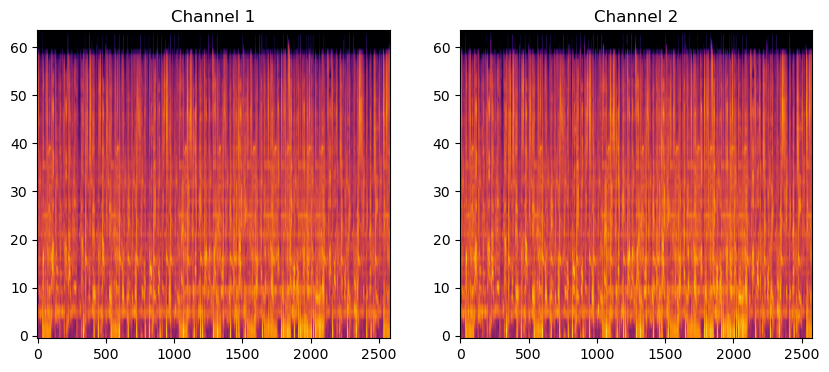

SIMILARITY: 972.31757
Elapsed time:  0.4928154945373535


In [343]:
import time
import soundfile
start = time.time()
n = 1
for filepath in audio_paths[:n]:
    sig,sr = torchaudio.load(filepath)
    label = torch.from_numpy(labels_onehot.loc[2].values).float()
    print("",label)
    print(torch.argmax(label))
    max_len = 44_100//1000 * 30_000
    
    # convert mono to stereo
    if sig.shape[0] != 2:
        sig = torch.cat([sig,sig])

    # standardize sampling rate , since Resample applies to a single channel, we resample one channel at a time :D
    # resample first channel
    if sr != 44100:
        num_channels = sig.shape[0]
        sig1 = torchaudio.transforms.Resample(sr, 44100)(sig[:1,:])
        if (num_channels > 1):
            #resample the second channel and merge both channels
            retwo = torchaudio.transforms.Resample(sr, 44100)(sig[1:,:])
            sig = torch.cat([sig1,retwo])
        else:
            sig = sig1


    num_rows, sig_len = sig.shape
    
    if (sig_len > max_len):
        # Truncate the signal to the given length
        sig = sig[:,:max_len] 
    elif (sig_len < max_len):
        # length of padding to add at the beginning and end of the signal
        pad_begin_len = random.randint(0, max_len - sig_len)
        pad_end_len = max_len - sig_len - pad_begin_len  
        # pad with 0s
        pad_begin = torch.zeros((num_rows, pad_begin_len))
        pad_end = torch.zeros((num_rows, pad_end_len))

        sig = torch.cat((pad_begin, sig, pad_end), 1)
    sig.shape
    aud = sig, 44_100
    spec = mel_spec(aud, n_mels=64, n_fft=1024, hop_len=None)
    print(spec.shape)
    
    # Create a 2x1 grid of subplots
    fig, ax = plt.subplots(nrows=1, ncols=2,figsize = (10,4))

    # Plot the spectrogram of the first channel in the first subplot
    ax[0].imshow(spec[0].numpy(), origin='lower', aspect='auto', cmap='inferno')
    ax[0].set_title('Channel 1')

    # Plot the spectrogram of the second channel in the second subplot
    ax[1].imshow(spec[1].numpy(), origin='lower', aspect='auto', cmap='inferno')
    ax[1].set_title('Channel 2')

    # Show the figure
    plt.show()
    
    #"similarity" between specs
    spectrogram_right = spec[0] # The right channel spectrogram
    spectrogram_left = spec[1] # The left channel spectrogram
    distance = np.linalg.norm(spectrogram_right - spectrogram_left)
    print("SIMILARITY:",distance)
elapsed = time.time() - start
print("Elapsed time: ", elapsed)

----------

**Adding spectrogram data augmentation:** <br>
We will use a technique called SpecAugment that uses these two methods:

- **Frequency mask** : randomly mask out a range of consecutive frequencies by adding horizontal bars on the spectrogram.
- **Time mask** : similar to frequency masks, except that we randomly block out ranges of time from the spectrogram by using vertical bars.

In [183]:
def spectro_augment(spec,max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
        aug_spec = torchaudio.transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
        aug_spec = torchaudio.transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec

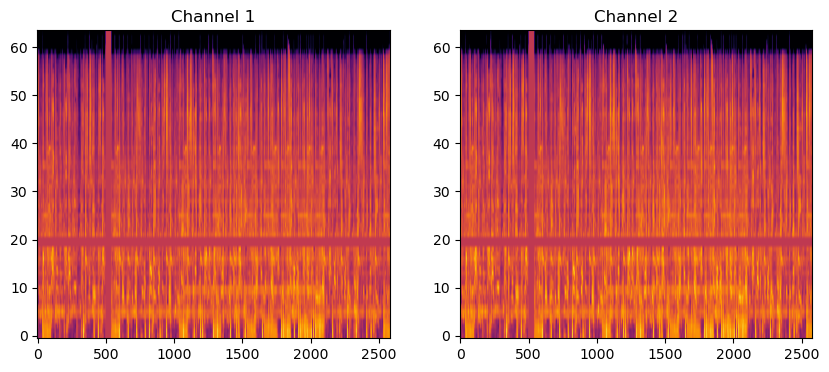

In [184]:
#testing on this:
aug_spec = spectro_augment(spec)
aug_spec.shape

#plotting it
# Create a 2x1 grid of subplots
fig, ax = plt.subplots(nrows=1, ncols=2,figsize = (10,4))

# Plot the spectrogram of the first channel in the first subplot
ax[0].imshow(aug_spec[0].numpy(), origin='lower', aspect='auto', cmap='inferno')
ax[0].set_title('Channel 1')

# Plot the spectrogram of the second channel in the second subplot
ax[1].imshow(aug_spec[1].numpy(), origin='lower', aspect='auto', cmap='inferno')
ax[1].set_title('Channel 2')

# Show the figure
plt.show()

----------

__Plotting one spectrogram__ <br> <br>
- Y-axis = Mel-frequencies
- X-axis = time in terms of audio samples

__similarity between spectrograms:__ <br>
Lower values of the Euclidean distance indicate that the left and right channel are similar, while higher values indicate that they are dissimilar.

In [15]:
# similarity between spectrograms
import numpy as np

# Compute the Euclidean distance between the two spectrograms
spectrogram_right = spec[0] # The right channel spectrogram
spectrogram_left = spec[1] # The left channel spectrogram
distance = np.linalg.norm(spectrogram_right - spectrogram_left)
distance

972.31757

--------------------------------------------------------------------------------------------------------------------------------

__Note : Using _stereo_ signals instead of mono, as for music genre classification this seems to be better :__ <br>
For music genre classification, using stereo signals may be beneficial as it can provide more information about the audio to the CNN. The spatial characteristics of the sound in a stereo signal can contain information about the instruments used, the arrangement and mixing of the audio, and other features that may be specific to certain genres of music.<br> <br>
The MelSpectrogram function applies a Mel-frequency filter bank to the signal, which maps the linear frequency scale of the signal to a mel-frequency scale, which is more perceptually meaningful for humans, and then applies the Short-time Fourier Transform (STFT) to the signal. The resulting complex numbers are squared to obtain the power spectrum.

--------------


**computing spectrograms and putting them in a folder for faster data processing when training** <br>

In [137]:
"""import os
import torch
import torchaudio
from torchaudio.transforms import Spectrogram

data_dir = '/Users/loren/OneDrive/Bureau/NNDL Project/data/fma_small'
output_dir = 'C:/Users/loren/OneDrive/Bureau/NNDL Project/augmented_spectrograms'
sampling_rate = 44_100
max_ms = 30_000

# create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
# loop through all MP3 files in the data directory
for root, dirs, files in os.walk(data_dir):
    for filename in files:
        if filename.endswith('.mp3'):
            filepath = os.path.join(root, filename)
            try: 
                sig, sr = torchaudio.load(filepath)
                # convert mono to stereo
                if sig.shape[0] != 2:
                    sig = torch.cat([sig, sig])
    
                # resample to the desired sampling rate
                if sr != sampling_rate:
                    sig = torchaudio.transforms.Resample(sr, sampling_rate)(sig)

                # resize to a fixed length
                num_rows, sig_len = sig.shape
                max_len = 44_100//1000 * max_ms
                if sig_len > max_len:
                    sig = sig[:, :max_len]
                elif sig_len < max_len:
                    pad_begin_len = random.randint(0, max_len - sig_len)
                    pad_end_len = max_len - sig_len - pad_begin_len
                    pad_begin = torch.zeros((num_rows, pad_begin_len))
                    pad_end = torch.zeros((num_rows, pad_end_len))
                    sig = torch.cat((pad_begin, sig, pad_end), 1)

                # compute the spectrogram
                spectro = mel_spec(aud = (sig,44_100), n_mels=64, n_fft=1024, hop_len=None)
                # *NEW* data augmentation computation
                spectro = spectro_augment(spectro)

                # save the spectrogram to the output directory
                output_file = os.path.join(output_dir, filename[:-4] + '.pt')
                torch.save(spectro, output_file)
            except Exception as e:
                print(e)
                continue"""

Unspecified internal error.
Unspecified internal error.
Unspecified internal error.
Error opening '/Users/loren/OneDrive/Bureau/NNDL Project/data/fma_small\\099\\099134.mp3': File does not exist or is not a regular file (possibly a pipe?).
Error opening '/Users/loren/OneDrive/Bureau/NNDL Project/data/fma_small\\108\\108925.mp3': File does not exist or is not a regular file (possibly a pipe?).


------------------

**NOTE: nn-CrossEntropyLoss() expects as the label one single value (number), so you have to convert the one-hot vector to the class label, which we do using torch.argmax()**

### Note: <br>
- **FMA2D** class processes the data at runtime
- **FMA2D_spec** class already has the pre-computed specs, it just loads them. *NEW* : augm proba added and also added the function spectro_augment inside
- **FMA2D_spec2** class loads also the augmented spectrograms

In [381]:
# creating the class for 2DCNN:
class FMA2D(Dataset):
    def __init__(self, data_dir, track_ids, sampling_rate=44_100, max_ms = 30_000):
        self.data_dir = data_dir
        self.filenames = os.listdir(data_dir)
        self.track_ids = track_ids
        self.sampling_rate = sampling_rate
        self.max_ms = max_ms
        
    def __getitem__(self,index):
        tid = self.track_ids[index]
        #load MP3 file
        filepath = utils.get_audio_path(self.data_dir, tid)
        try:
            sig, sr = torchaudio.load(filepath)
        except Exception as e:
            return self.__getitem__(index + 1)
        #label
        label = torch.argmax(torch.from_numpy(labels_onehot.loc[tid].values).float())
        #---------
        #if self.one_hot == True:
        #    label = torch.from_numpy(labels_onehot.loc[tid].values).float()
        #else:
        #label = genres.loc[tid].values
        #-------
        # convert mono to stereo
        if sig.shape[0] != 2:
            sig = torch.cat([sig,sig])
            
        # standardize sampling rate , since Resample applies to a single channel, we resample one channel at a time :D
        # resample first channel
        if sr != self.sampling_rate:
            num_channels = sig.shape[0]
            sig1 = torchaudio.transforms.Resample(sr, self.sampling_rate)(sig[:1,:])
            if (num_channels > 1):
                # resample the second channel and merge both channels
                retwo = torchaudio.transforms.Resample(sr, self.sampling_rate)(sig[1:,:])
                sig = torch.cat([sig1,retwo])
            elif num_channels == 1:
                sig = sig1
                
        # we resize audio samples to have the same length by either extending its duration by padding it with silence, or by
        # truncating it
        num_rows, sig_len = sig.shape
        max_len = 44_100//1000 * self.max_ms
        
        if (sig_len > max_len):
          # Truncate the signal to the given length
          sig = sig[:,:max_len] 
            
        elif (sig_len < max_len):
            # length of paddinf to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len  
            # pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))
            
            sig = torch.cat((pad_begin, sig, pad_end), 1)
        
        # now we generate the spectrogram
        aud = sig, self.sampling_rate
        spec = mel_spec(aud, n_mels=64, n_fft=1024, hop_len=None)
        return spec, label
    
    def __len__(self):
        return len(self.track_ids)

In [382]:
class FMA2D_spec(Dataset):   
    def __init__(self, data_dir, track_ids,transforms = True, augment_prob = 0.5, max_mask_pct=0.3, n_freq_masks=2, n_time_masks=2):
        self.data_dir = data_dir
        self.filenames = os.listdir(data_dir)
        self.track_ids = track_ids
        self.transforms = transforms
        self.augment_prob = augment_prob
        self.max_mask_pct = max_mask_pct
        self.n_freq_masks = n_freq_masks
        self.n_time_masks = n_time_masks
        
    def __getitem__(self, index):
        tid = self.track_ids[index]
        # load the spectrogram data
        spec_path = os.path.join('./spectrograms/'+"{:06d}".format(tid)+'.pt')
        try:
            spec = torch.load(spec_path)
        except Exception as e:
            return self.__getitem__(index + 1)
        if self.transforms is True and torch.rand(1) < self.augment_prob:
            spec = self.spectro_augment(spec)
        #get label
        label = torch.argmax(torch.from_numpy(labels_onehot.loc[tid].values).float())
        return spec, label
        
    def __len__(self):
        return len(self.track_ids)
    
    def spectro_augment(self, spec):
        _, n_mels, n_steps = spec.shape
        mask_value = spec.mean()
        aug_spec = spec

        freq_mask_param = self.max_mask_pct * n_mels
        for _ in range(self.n_freq_masks):
            aug_spec = torchaudio.transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

        time_mask_param = self.max_mask_pct * n_steps
        for _ in range(self.n_time_masks):
            aug_spec = torchaudio.transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

        return aug_spec


In [383]:
class FMA2D_spec2(Dataset):   
    def __init__(self, data_dir, track_ids):
        self.data_dir = data_dir
        self.filenames = os.listdir(data_dir)
        self.track_ids = track_ids
        self.paths = []
        folders = ['spectrograms', 'augmented_spectrograms']
        for folder in folders:
            for tid in track_ids:
                self.paths.append([os.path.join(f'./{folder}/'+"{:06d}".format(tid)+'.pt'), tid])
        
    def __getitem__(self, index):
        # load the spectrogram data
        spec_path = self.paths[index][0]
        label = torch.argmax(torch.from_numpy(labels_onehot.loc[self.paths[index][1]].values).float())
        try:
            spec = torch.load(spec_path)
        except Exception as e:
            return self.__getitem__(index + 1)
        #get label
        
        return spec, label
        
    def __len__(self):
        return len(self.track_ids)*2

--------------------------------------------------------------------------------------------------------------------------------

## Model training and testing

### Model : SimpleCNN

In [384]:
import torch.nn.functional as F
from torch.nn import init

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Third Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Fourth Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=8)

        self.conv = nn.Sequential(*conv_layers)
 
    def forward(self, x):
        x = self.conv(x)
        x = self.ap(x)
        x = x.view(x.shape[0], -1)
        x = self.lin(x)
        return x

# to start with a clean clean slate at each iteration, if you don't do zero_grad(),  
# the running sum of gradients in batch normalization layers isn't reset
myModel = None
myModel = SimpleCNN()
myModel.zero_grad()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cuda', index=0)

### Data loading and data augmentation specifications

In [385]:
dataset_train = FMA2D_spec(DATA_DIR, train_ids, transforms = True, augment_prob = 0.9
                           ,max_mask_pct=0.2, n_freq_masks=1, n_time_masks=1)
dataset_valid = FMA2D_spec(DATA_DIR, val_ids, transforms = False)
dataset_test = FMA2D_spec(DATA_DIR, test_ids, transforms = False)


# Create training and validation data loaders
train_dl_sp = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)
val_dl_sp = torch.utils.data.DataLoader(dataset_valid, batch_size=32, shuffle=True)

#### to take a smaller training data

In [388]:
subsampling = False
if subsampling is True:    
    subsample_size = 3_520
    subsample_dataset_train = torch.utils.data.Subset(dataset_train, indices=range(subsample_size))
    train_dl_sp = torch.utils.data.DataLoader(subsample_dataset_train, batch_size=32, shuffle=True)

    val_subsample_size = 416
    subsample_dataset_valid = torch.utils.data.Subset(dataset_valid, indices=range(val_subsample_size))
    val_dl_sp = torch.utils.data.DataLoader(subsample_dataset_valid, batch_size=32, shuffle=True)

#### checking out how a batch size looks like

In [389]:
for data, label in train_dl_sp:
    print(data.shape,"\n",label.shape)
    print(label)
    break
print(len(train_dl_sp))

for data, label in val_dl_sp:
    print(data.shape,"\n",label.shape)
    print(label)
    break
print(len(val_dl_sp))

torch.Size([32, 2, 64, 2579]) 
 torch.Size([32])
tensor([7, 0, 0, 5, 1, 2, 2, 6, 4, 4, 5, 1, 4, 1, 0, 2, 5, 5, 5, 4, 0, 0, 1, 6,
        7, 2, 0, 3, 1, 2, 6, 7])
200
torch.Size([32, 2, 64, 2579]) 
 torch.Size([32])
tensor([1, 1, 5, 6, 7, 5, 7, 2, 0, 3, 5, 6, 7, 7, 5, 5, 0, 3, 6, 6, 3, 4, 1, 4,
        6, 6, 4, 6, 6, 7, 6, 5])
25


#### Training and validation

In [ ]:
def training_valid(model, train_dl_sp, val_dl_sp, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.001,weight_decay = 0.001)
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,steps_per_epoch=int(len(train_dl_sp)),
    #                                            epochs=num_epochs,
    #                                            anneal_strategy='linear')
    
    train_accs = []
    val_accs = []
    train_losses = []
    val_losses = []
    number_of_samples = 0
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0
        for i, (data,label) in enumerate(train_dl_sp):
            number_of_samples += 1
            inputs, labels = data.to(device), label.to(device)
            #inputs_m, inputs_s = inputs.mean(), inputs.std()
            #inputs = (inputs - inputs_m) / inputs_s

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # ADDED .zero_grad() now
            model.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()
            #NOTE : the "prediction" here below is the index of the max value of the output tensor
            # _ is the output tensor (1D 8component tensor) and pred is the index
            _, prediction = torch.max(outputs,1)
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
            if total_prediction == 0:
                acc = 0
            else:
                acc = correct_prediction/total_prediction

        num_batches = len(train_dl_sp)
        train_loss = running_loss / num_batches
        train_accs.append(acc)
        train_losses.append(train_loss)
        print(f'Epoch: {epoch}, Train Loss: {train_loss:.2f}, Training Accuracy: {acc:.2f}')
        model.eval()
        #Validation Loop
        with torch.no_grad():
            val_loss = 0.0
            val_correct_prediction = 0
            val_total_prediction = 0
            for data, label in val_dl_sp:
                inputs, labels = data.to(device), label.to(device)
                #inputs_m, inputs_s = inputs.mean(), inputs.std()
                #inputs = (inputs - inputs_m) / inputs_s
                outputs = model(inputs)
                val_loss += criterion(outputs, labels)
                _, val_prediction = torch.max(outputs,1)
                val_correct_prediction += (val_prediction == labels).sum().item()
                val_total_prediction += val_prediction.shape[0]
                if val_total_prediction == 0:
                    val_acc = 0
                else:
                    val_acc = val_correct_prediction/val_total_prediction
            val_loss /= len(val_dl_sp)
            val_accs.append(val_acc)
            val_losses.append(val_loss)
            print(f' Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')
            print("--------------------------------------------")
        model.train()
        
    # max validation acc
    print(max(val_accs))
    #plotting results
    fig, axs = plt.subplots(1,2,figsize = (15,5))
    
    #accuracies
    axs[0].plot(train_accs, label='Training Accuracy')
    axs[0].plot(val_accs, label='Validation Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    
    #losses
    val_losses = torch.tensor(val_losses)
    axs[1].plot(train_losses, label='Training Loss')
    axs[1].plot(val_losses.detach().numpy(), label='Validation Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    plt.show()
    

training_valid(myModel, train_dl_sp, val_dl_sp, num_epochs = 100)

#### Testing

In [418]:
#dataset 
dataset_test = FMA2D_spec(DATA_DIR, test_ids, transforms = False)
test_dl_sp = torch.utils.data.DataLoader(dataset_test, batch_size=800, shuffle=True)

def testing(model, train_data):
    correct_prediction = 0
    total_prediction = 0

  # Disable gradient updates
    with torch.no_grad():
        for data in train_data:
            # Get the input features and target labels, and put them on the GPU
            inputs, labels = data[0].to(device), data[1].to(device)

            # Normalize the inputs
            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            # Get predictions
            outputs = model(inputs)

            # Get the predicted class with the highest score
            _, prediction = torch.max(outputs,1)
            # Count of predictions that matched the target label
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

    acc = correct_prediction/total_prediction
    print(f'Accuracy: {acc:.4f}, Total items: {total_prediction}')

# Run inference on trained model with the validation set
testing(myModel, test_dl_sp)

Accuracy: 0.4838, Total items: 800


In [185]:
total_params = sum(p.numel() for p in myModel.parameters())

print(f'The model has {total_params} parameters.')

The model has 25472 parameters.


In [358]:
import torchinfo
torchinfo.summary(myModel, input_size =(32, 2, 64, 2579))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [32, 8]                   --
├─Sequential: 1-1                        [32, 64, 4, 162]          --
│    └─Conv2d: 2-1                       [32, 8, 32, 1290]         408
│    └─ReLU: 2-2                         [32, 8, 32, 1290]         --
│    └─BatchNorm2d: 2-3                  [32, 8, 32, 1290]         16
│    └─Conv2d: 2-4                       [32, 16, 16, 645]         1,168
│    └─ReLU: 2-5                         [32, 16, 16, 645]         --
│    └─BatchNorm2d: 2-6                  [32, 16, 16, 645]         32
│    └─Conv2d: 2-7                       [32, 32, 8, 323]          4,640
│    └─ReLU: 2-8                         [32, 32, 8, 323]          --
│    └─BatchNorm2d: 2-9                  [32, 32, 8, 323]          64
│    └─Conv2d: 2-10                      [32, 64, 4, 162]          18,496
│    └─ReLU: 2-11                        [32, 64, 4, 162]          --
│   

----

## Gridsearch

### 24 x 50 epochs, 1 epoch +/- 35s so **11.6h** expected gridsearch time

- using 6400 samples

aug_prob:0.7, max_mask_pct:0.1,n_freq_masks:1,n_time_masks:1
Epoch: 0, Train Loss: 1.99, Training Accuracy: 0.23
 Validation Loss: 1.93, Validation Accuracy: 0.25
--------------------------------------------
Epoch: 1, Train Loss: 1.87, Training Accuracy: 0.30
 Validation Loss: 1.81, Validation Accuracy: 0.35
--------------------------------------------
Epoch: 2, Train Loss: 1.77, Training Accuracy: 0.37
 Validation Loss: 1.68, Validation Accuracy: 0.38
--------------------------------------------
Epoch: 3, Train Loss: 1.66, Training Accuracy: 0.40
 Validation Loss: 1.62, Validation Accuracy: 0.40
--------------------------------------------
Epoch: 4, Train Loss: 1.61, Training Accuracy: 0.42
 Validation Loss: 1.58, Validation Accuracy: 0.42
--------------------------------------------
Epoch: 5, Train Loss: 1.57, Training Accuracy: 0.44
 Validation Loss: 1.56, Validation Accuracy: 0.44
--------------------------------------------
Epoch: 6, Train Loss: 1.54, Training Accuracy: 0.45
 Vali

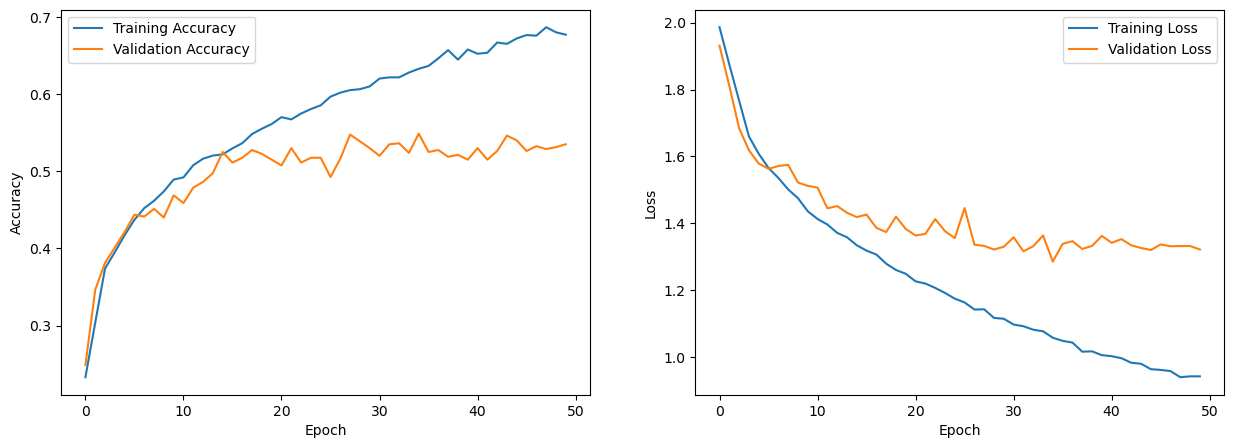

aug_prob:0.7, max_mask_pct:0.1,n_freq_masks:2,n_time_masks:2
Epoch: 0, Train Loss: 2.00, Training Accuracy: 0.22
 Validation Loss: 1.93, Validation Accuracy: 0.26
--------------------------------------------
Epoch: 1, Train Loss: 1.85, Training Accuracy: 0.31
 Validation Loss: 1.79, Validation Accuracy: 0.31
--------------------------------------------
Epoch: 2, Train Loss: 1.73, Training Accuracy: 0.36
 Validation Loss: 1.70, Validation Accuracy: 0.36
--------------------------------------------
Epoch: 3, Train Loss: 1.67, Training Accuracy: 0.38
 Validation Loss: 1.66, Validation Accuracy: 0.38
--------------------------------------------
Epoch: 4, Train Loss: 1.62, Training Accuracy: 0.42
 Validation Loss: 1.62, Validation Accuracy: 0.40
--------------------------------------------
Epoch: 5, Train Loss: 1.57, Training Accuracy: 0.43
 Validation Loss: 1.56, Validation Accuracy: 0.45
--------------------------------------------
Epoch: 6, Train Loss: 1.55, Training Accuracy: 0.44
 Vali

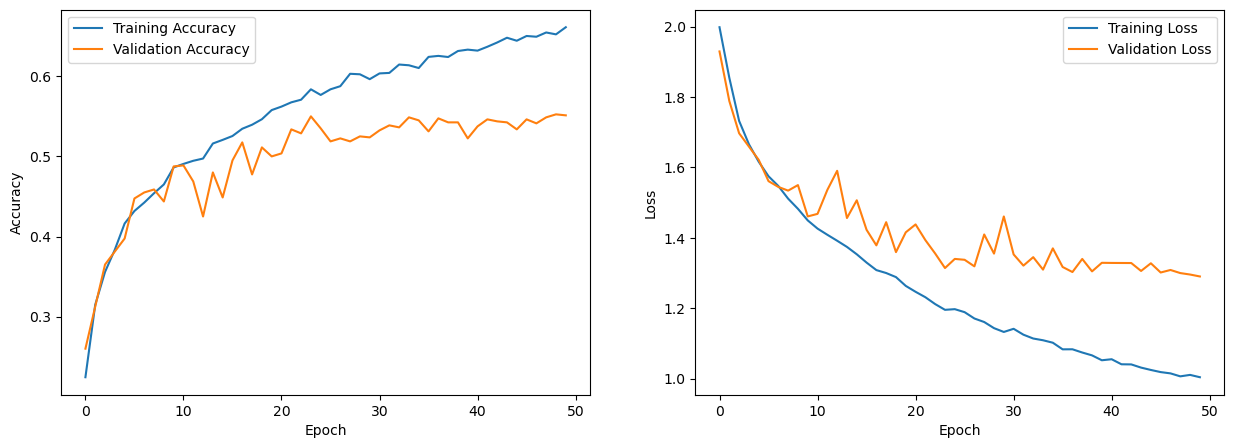

aug_prob:0.7, max_mask_pct:0.2,n_freq_masks:1,n_time_masks:1
Epoch: 0, Train Loss: 2.02, Training Accuracy: 0.20
 Validation Loss: 1.92, Validation Accuracy: 0.28
--------------------------------------------
Epoch: 1, Train Loss: 1.85, Training Accuracy: 0.32
 Validation Loss: 1.75, Validation Accuracy: 0.35
--------------------------------------------
Epoch: 2, Train Loss: 1.73, Training Accuracy: 0.36
 Validation Loss: 1.68, Validation Accuracy: 0.36
--------------------------------------------
Epoch: 3, Train Loss: 1.67, Training Accuracy: 0.39
 Validation Loss: 1.68, Validation Accuracy: 0.40
--------------------------------------------
Epoch: 4, Train Loss: 1.62, Training Accuracy: 0.41
 Validation Loss: 1.70, Validation Accuracy: 0.39
--------------------------------------------
Epoch: 5, Train Loss: 1.59, Training Accuracy: 0.42
 Validation Loss: 1.62, Validation Accuracy: 0.41
--------------------------------------------
Epoch: 6, Train Loss: 1.55, Training Accuracy: 0.44
 Vali

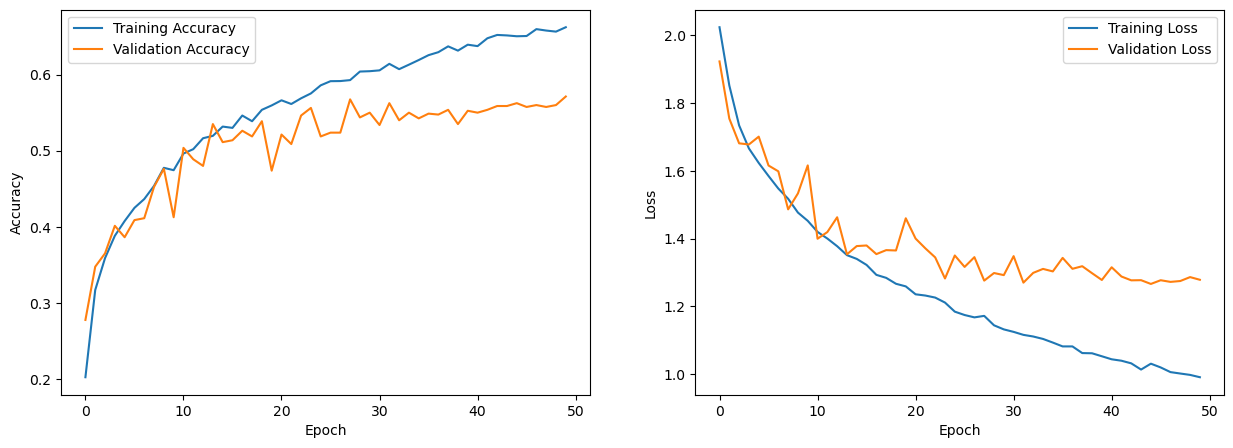

aug_prob:0.7, max_mask_pct:0.2,n_freq_masks:2,n_time_masks:2
Epoch: 0, Train Loss: 2.01, Training Accuracy: 0.19
 Validation Loss: 1.92, Validation Accuracy: 0.24
--------------------------------------------
Epoch: 1, Train Loss: 1.87, Training Accuracy: 0.30
 Validation Loss: 1.78, Validation Accuracy: 0.34
--------------------------------------------
Epoch: 2, Train Loss: 1.75, Training Accuracy: 0.35
 Validation Loss: 1.71, Validation Accuracy: 0.39
--------------------------------------------
Epoch: 3, Train Loss: 1.69, Training Accuracy: 0.38
 Validation Loss: 1.64, Validation Accuracy: 0.39
--------------------------------------------
Epoch: 4, Train Loss: 1.65, Training Accuracy: 0.39
 Validation Loss: 1.64, Validation Accuracy: 0.38
--------------------------------------------
Epoch: 5, Train Loss: 1.63, Training Accuracy: 0.40
 Validation Loss: 1.57, Validation Accuracy: 0.44
--------------------------------------------
Epoch: 6, Train Loss: 1.59, Training Accuracy: 0.42
 Vali

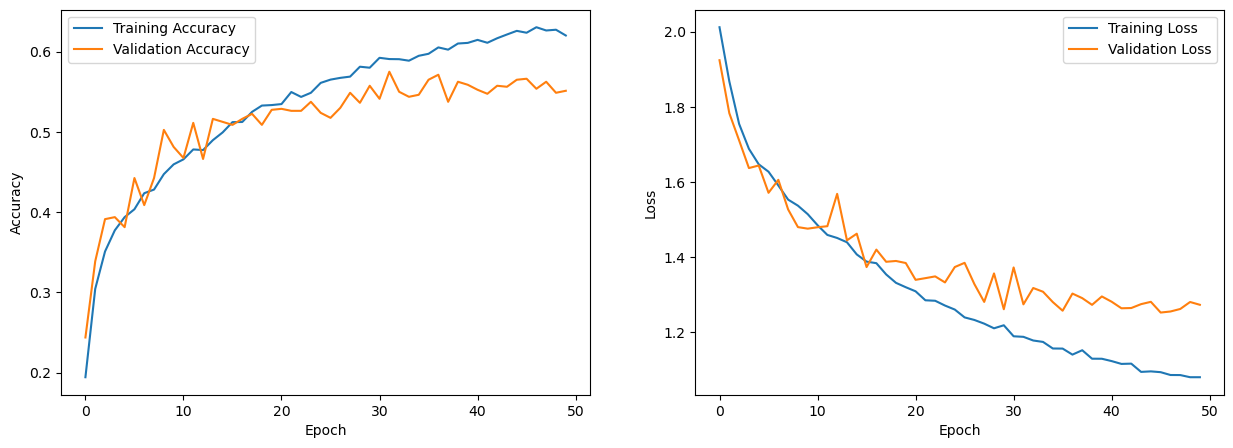

aug_prob:0.7, max_mask_pct:0.3,n_freq_masks:1,n_time_masks:1
Epoch: 0, Train Loss: 2.02, Training Accuracy: 0.20
 Validation Loss: 1.94, Validation Accuracy: 0.25
--------------------------------------------
Epoch: 1, Train Loss: 1.88, Training Accuracy: 0.30
 Validation Loss: 1.82, Validation Accuracy: 0.32
--------------------------------------------
Epoch: 2, Train Loss: 1.77, Training Accuracy: 0.35
 Validation Loss: 1.70, Validation Accuracy: 0.39
--------------------------------------------
Epoch: 3, Train Loss: 1.68, Training Accuracy: 0.38
 Validation Loss: 1.66, Validation Accuracy: 0.40
--------------------------------------------
Epoch: 4, Train Loss: 1.64, Training Accuracy: 0.39
 Validation Loss: 1.62, Validation Accuracy: 0.41
--------------------------------------------
Epoch: 5, Train Loss: 1.61, Training Accuracy: 0.41
 Validation Loss: 1.60, Validation Accuracy: 0.41
--------------------------------------------
Epoch: 6, Train Loss: 1.58, Training Accuracy: 0.42
 Vali

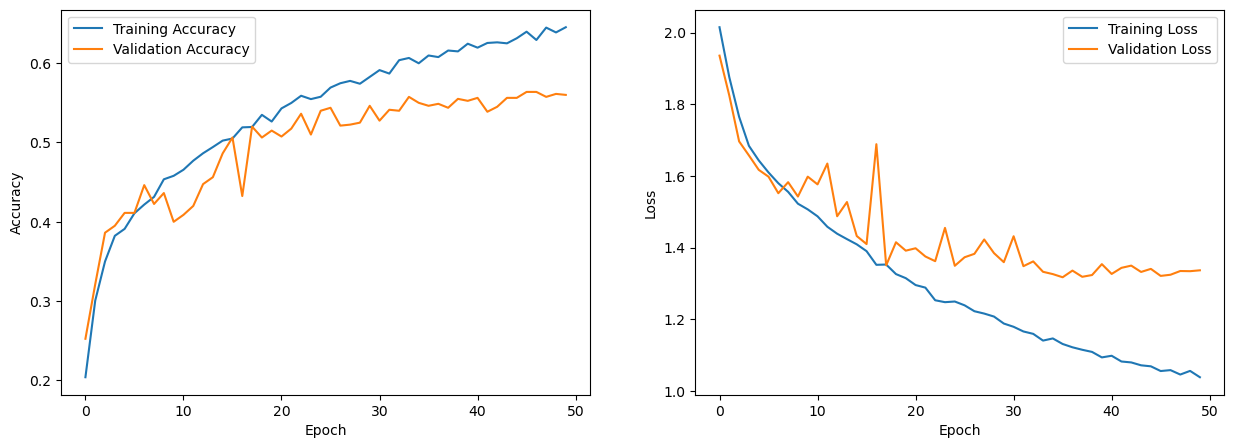

aug_prob:0.7, max_mask_pct:0.3,n_freq_masks:2,n_time_masks:2
Epoch: 0, Train Loss: 1.98, Training Accuracy: 0.23
 Validation Loss: 1.91, Validation Accuracy: 0.32
--------------------------------------------
Epoch: 1, Train Loss: 1.86, Training Accuracy: 0.30
 Validation Loss: 1.80, Validation Accuracy: 0.33
--------------------------------------------
Epoch: 2, Train Loss: 1.78, Training Accuracy: 0.33
 Validation Loss: 1.74, Validation Accuracy: 0.34
--------------------------------------------
Epoch: 3, Train Loss: 1.73, Training Accuracy: 0.36
 Validation Loss: 1.68, Validation Accuracy: 0.36
--------------------------------------------
Epoch: 4, Train Loss: 1.70, Training Accuracy: 0.37
 Validation Loss: 1.63, Validation Accuracy: 0.40
--------------------------------------------
Epoch: 5, Train Loss: 1.67, Training Accuracy: 0.39
 Validation Loss: 1.62, Validation Accuracy: 0.41
--------------------------------------------
Epoch: 6, Train Loss: 1.64, Training Accuracy: 0.40
 Vali

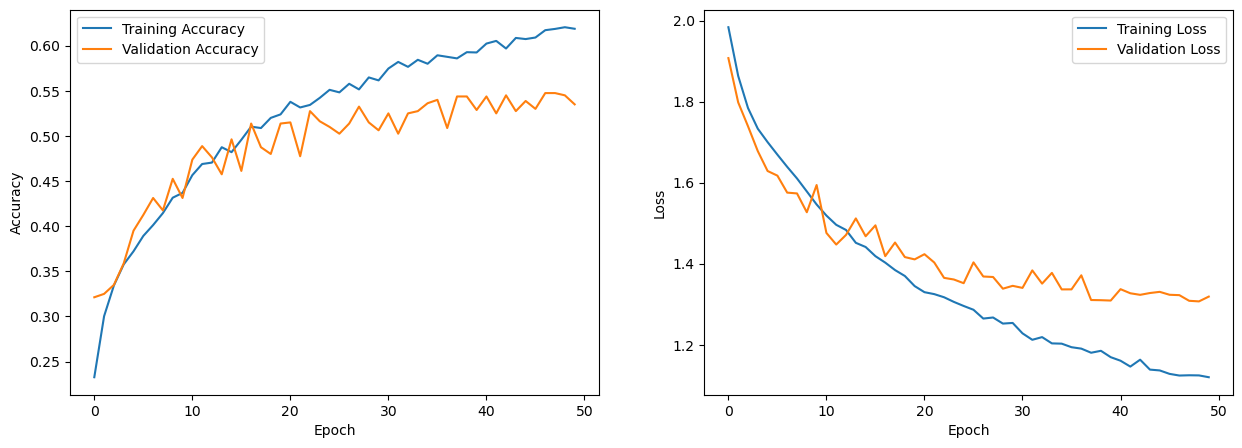

aug_prob:0.8, max_mask_pct:0.1,n_freq_masks:1,n_time_masks:1
Epoch: 0, Train Loss: 1.98, Training Accuracy: 0.25
 Validation Loss: 1.90, Validation Accuracy: 0.27
--------------------------------------------
Epoch: 1, Train Loss: 1.84, Training Accuracy: 0.31
 Validation Loss: 1.80, Validation Accuracy: 0.33
--------------------------------------------
Epoch: 2, Train Loss: 1.75, Training Accuracy: 0.36
 Validation Loss: 1.70, Validation Accuracy: 0.37
--------------------------------------------
Epoch: 3, Train Loss: 1.66, Training Accuracy: 0.39
 Validation Loss: 1.64, Validation Accuracy: 0.39
--------------------------------------------
Epoch: 4, Train Loss: 1.60, Training Accuracy: 0.41
 Validation Loss: 1.59, Validation Accuracy: 0.42
--------------------------------------------
Epoch: 5, Train Loss: 1.56, Training Accuracy: 0.44
 Validation Loss: 1.58, Validation Accuracy: 0.43
--------------------------------------------
Epoch: 6, Train Loss: 1.52, Training Accuracy: 0.45
 Vali

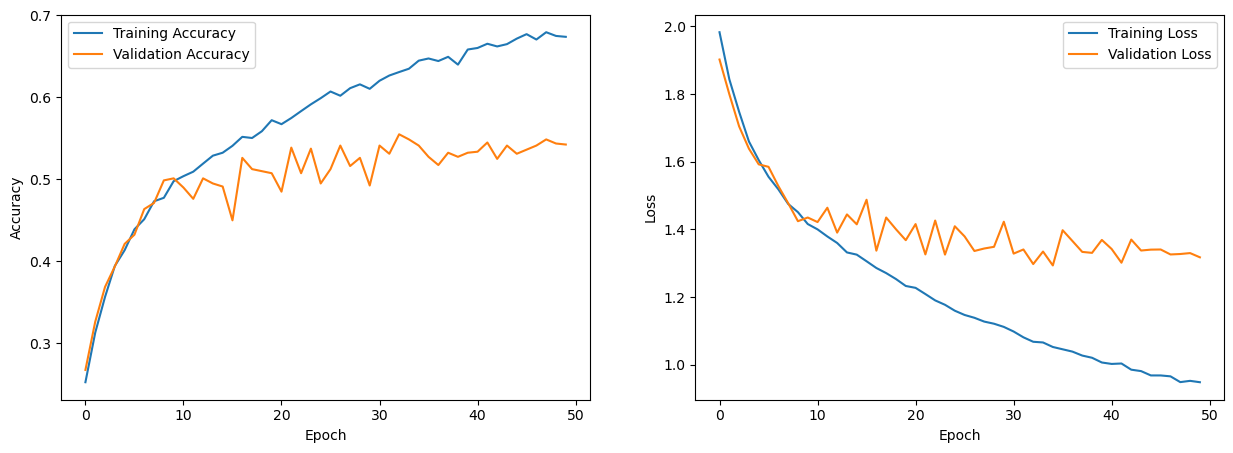

aug_prob:0.8, max_mask_pct:0.1,n_freq_masks:2,n_time_masks:2
Epoch: 0, Train Loss: 2.02, Training Accuracy: 0.19
 Validation Loss: 1.96, Validation Accuracy: 0.23
--------------------------------------------
Epoch: 1, Train Loss: 1.88, Training Accuracy: 0.30
 Validation Loss: 1.84, Validation Accuracy: 0.29
--------------------------------------------
Epoch: 2, Train Loss: 1.78, Training Accuracy: 0.34
 Validation Loss: 1.75, Validation Accuracy: 0.35
--------------------------------------------
Epoch: 3, Train Loss: 1.70, Training Accuracy: 0.37
 Validation Loss: 1.69, Validation Accuracy: 0.38
--------------------------------------------
Epoch: 4, Train Loss: 1.65, Training Accuracy: 0.40
 Validation Loss: 1.63, Validation Accuracy: 0.41
--------------------------------------------
Epoch: 5, Train Loss: 1.61, Training Accuracy: 0.42
 Validation Loss: 1.62, Validation Accuracy: 0.41
--------------------------------------------
Epoch: 6, Train Loss: 1.57, Training Accuracy: 0.44
 Vali

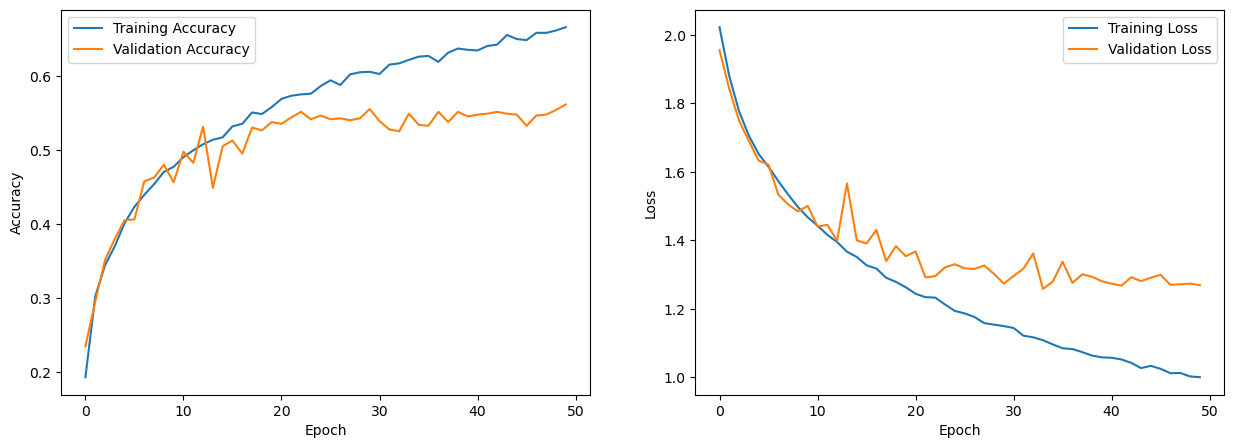

aug_prob:0.8, max_mask_pct:0.2,n_freq_masks:1,n_time_masks:1
Epoch: 0, Train Loss: 2.00, Training Accuracy: 0.23
 Validation Loss: 1.92, Validation Accuracy: 0.28
--------------------------------------------
Epoch: 1, Train Loss: 1.86, Training Accuracy: 0.31
 Validation Loss: 1.79, Validation Accuracy: 0.34
--------------------------------------------
Epoch: 2, Train Loss: 1.76, Training Accuracy: 0.36
 Validation Loss: 1.70, Validation Accuracy: 0.38
--------------------------------------------
Epoch: 3, Train Loss: 1.68, Training Accuracy: 0.39
 Validation Loss: 1.69, Validation Accuracy: 0.39
--------------------------------------------
Epoch: 4, Train Loss: 1.64, Training Accuracy: 0.40
 Validation Loss: 1.64, Validation Accuracy: 0.41
--------------------------------------------
Epoch: 5, Train Loss: 1.59, Training Accuracy: 0.43
 Validation Loss: 1.56, Validation Accuracy: 0.44
--------------------------------------------
Epoch: 6, Train Loss: 1.54, Training Accuracy: 0.45
 Vali

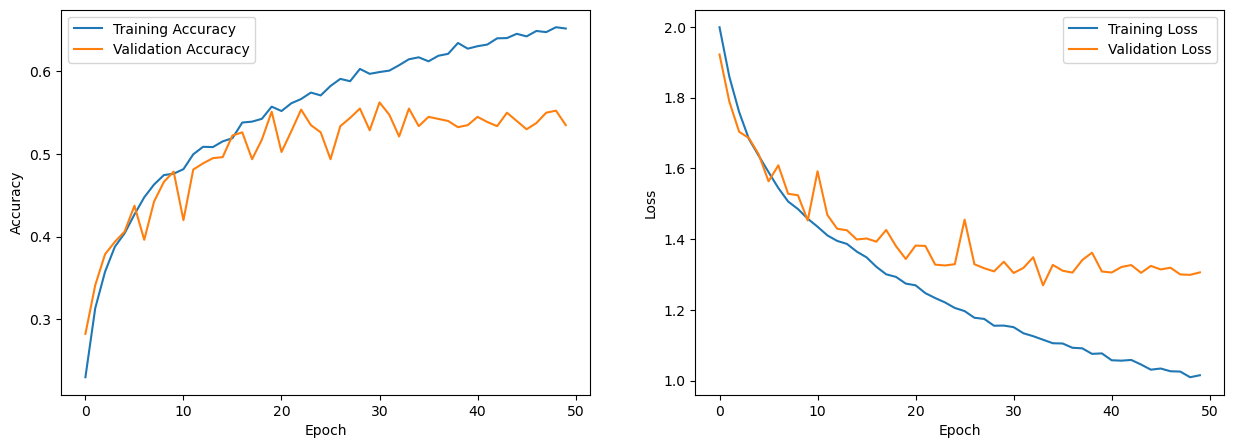

aug_prob:0.8, max_mask_pct:0.2,n_freq_masks:2,n_time_masks:2
Epoch: 0, Train Loss: 2.00, Training Accuracy: 0.21
 Validation Loss: 1.95, Validation Accuracy: 0.26
--------------------------------------------
Epoch: 1, Train Loss: 1.88, Training Accuracy: 0.29
 Validation Loss: 1.84, Validation Accuracy: 0.32
--------------------------------------------
Epoch: 2, Train Loss: 1.80, Training Accuracy: 0.34
 Validation Loss: 1.72, Validation Accuracy: 0.35
--------------------------------------------
Epoch: 3, Train Loss: 1.73, Training Accuracy: 0.37
 Validation Loss: 1.67, Validation Accuracy: 0.38
--------------------------------------------
Epoch: 4, Train Loss: 1.67, Training Accuracy: 0.38
 Validation Loss: 1.65, Validation Accuracy: 0.40
--------------------------------------------
Epoch: 5, Train Loss: 1.64, Training Accuracy: 0.40
 Validation Loss: 1.71, Validation Accuracy: 0.39
--------------------------------------------
Epoch: 6, Train Loss: 1.61, Training Accuracy: 0.42
 Vali

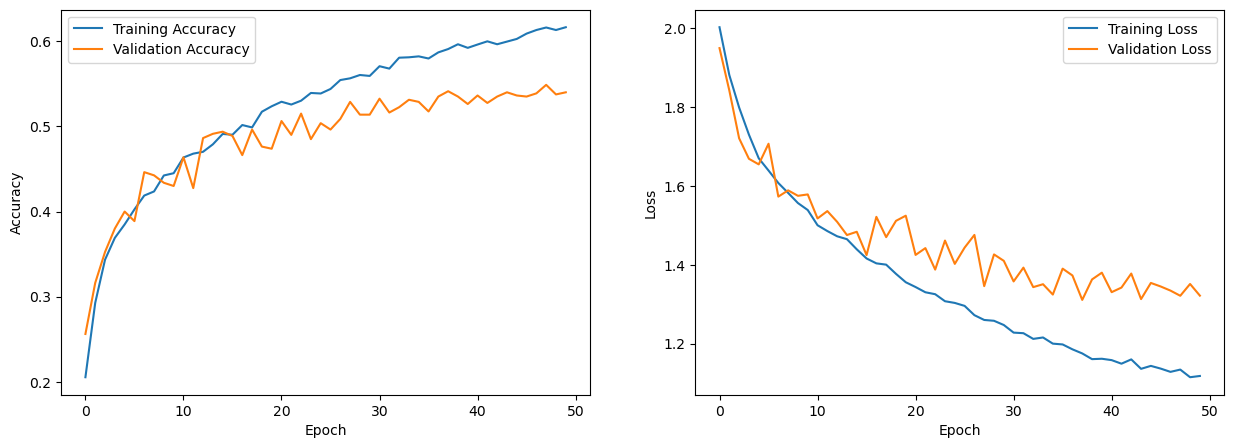

aug_prob:0.8, max_mask_pct:0.3,n_freq_masks:1,n_time_masks:1
Epoch: 0, Train Loss: 2.01, Training Accuracy: 0.21
 Validation Loss: 1.95, Validation Accuracy: 0.24
--------------------------------------------
Epoch: 1, Train Loss: 1.86, Training Accuracy: 0.30
 Validation Loss: 1.80, Validation Accuracy: 0.31
--------------------------------------------
Epoch: 2, Train Loss: 1.75, Training Accuracy: 0.36
 Validation Loss: 1.71, Validation Accuracy: 0.39
--------------------------------------------
Epoch: 3, Train Loss: 1.69, Training Accuracy: 0.39
 Validation Loss: 1.66, Validation Accuracy: 0.40
--------------------------------------------
Epoch: 4, Train Loss: 1.64, Training Accuracy: 0.41
 Validation Loss: 1.63, Validation Accuracy: 0.42
--------------------------------------------
Epoch: 5, Train Loss: 1.61, Training Accuracy: 0.42
 Validation Loss: 1.61, Validation Accuracy: 0.43
--------------------------------------------
Epoch: 6, Train Loss: 1.57, Training Accuracy: 0.44
 Vali

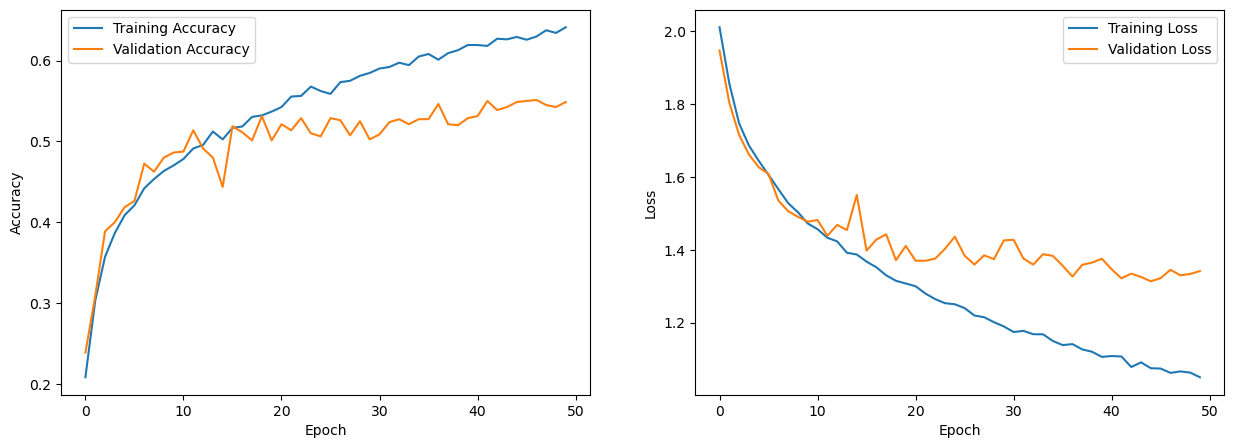

aug_prob:0.8, max_mask_pct:0.3,n_freq_masks:2,n_time_masks:2
Epoch: 0, Train Loss: 2.00, Training Accuracy: 0.21
 Validation Loss: 1.94, Validation Accuracy: 0.24
--------------------------------------------
Epoch: 1, Train Loss: 1.89, Training Accuracy: 0.28
 Validation Loss: 1.81, Validation Accuracy: 0.33
--------------------------------------------
Epoch: 2, Train Loss: 1.79, Training Accuracy: 0.34
 Validation Loss: 1.69, Validation Accuracy: 0.37
--------------------------------------------
Epoch: 3, Train Loss: 1.73, Training Accuracy: 0.35
 Validation Loss: 1.68, Validation Accuracy: 0.38
--------------------------------------------
Epoch: 4, Train Loss: 1.69, Training Accuracy: 0.37
 Validation Loss: 1.66, Validation Accuracy: 0.40
--------------------------------------------
Epoch: 5, Train Loss: 1.66, Training Accuracy: 0.38
 Validation Loss: 1.74, Validation Accuracy: 0.36
--------------------------------------------
Epoch: 6, Train Loss: 1.64, Training Accuracy: 0.40
 Vali

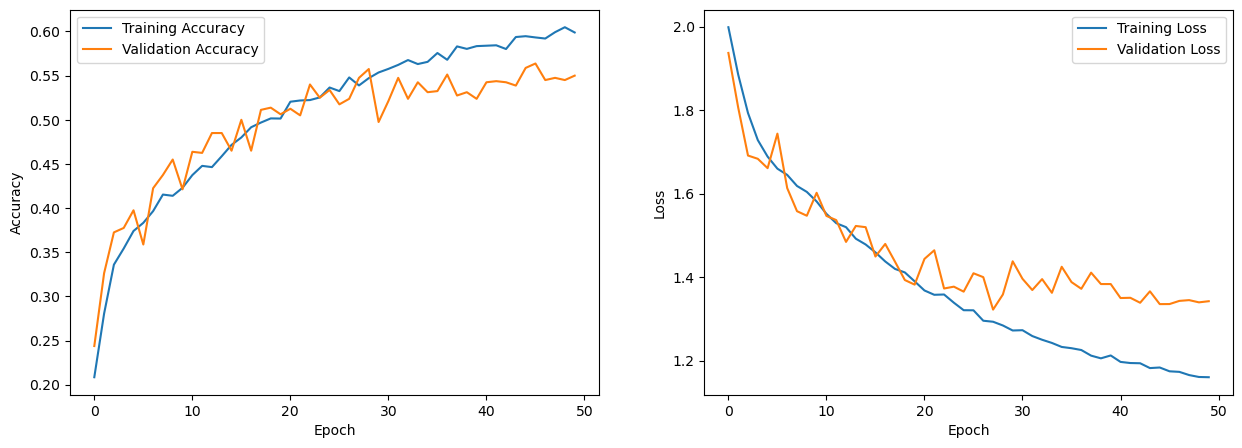

aug_prob:0.9, max_mask_pct:0.1,n_freq_masks:1,n_time_masks:1
Epoch: 0, Train Loss: 1.99, Training Accuracy: 0.24
 Validation Loss: 1.91, Validation Accuracy: 0.27
--------------------------------------------
Epoch: 1, Train Loss: 1.84, Training Accuracy: 0.32
 Validation Loss: 1.79, Validation Accuracy: 0.33
--------------------------------------------
Epoch: 2, Train Loss: 1.73, Training Accuracy: 0.36
 Validation Loss: 1.71, Validation Accuracy: 0.35
--------------------------------------------
Epoch: 3, Train Loss: 1.66, Training Accuracy: 0.40
 Validation Loss: 1.66, Validation Accuracy: 0.40
--------------------------------------------
Epoch: 4, Train Loss: 1.61, Training Accuracy: 0.41
 Validation Loss: 1.60, Validation Accuracy: 0.44
--------------------------------------------
Epoch: 5, Train Loss: 1.58, Training Accuracy: 0.44
 Validation Loss: 1.60, Validation Accuracy: 0.40
--------------------------------------------
Epoch: 6, Train Loss: 1.54, Training Accuracy: 0.45
 Vali

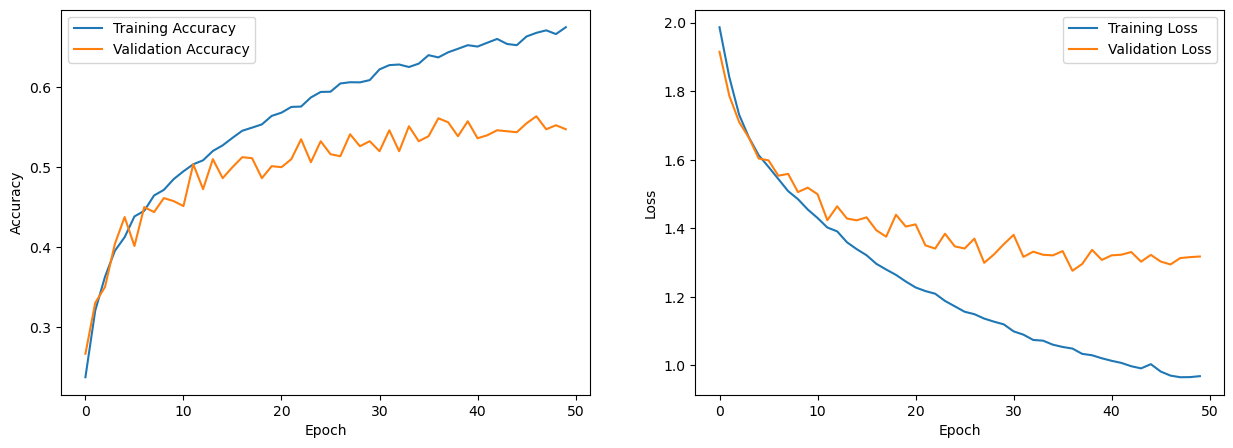

aug_prob:0.9, max_mask_pct:0.1,n_freq_masks:2,n_time_masks:2
Epoch: 0, Train Loss: 1.99, Training Accuracy: 0.23
 Validation Loss: 1.93, Validation Accuracy: 0.24
--------------------------------------------
Epoch: 1, Train Loss: 1.86, Training Accuracy: 0.30
 Validation Loss: 1.80, Validation Accuracy: 0.32
--------------------------------------------
Epoch: 2, Train Loss: 1.77, Training Accuracy: 0.34
 Validation Loss: 1.72, Validation Accuracy: 0.36
--------------------------------------------
Epoch: 3, Train Loss: 1.69, Training Accuracy: 0.38
 Validation Loss: 1.66, Validation Accuracy: 0.39
--------------------------------------------
Epoch: 4, Train Loss: 1.65, Training Accuracy: 0.40
 Validation Loss: 1.59, Validation Accuracy: 0.42
--------------------------------------------
Epoch: 5, Train Loss: 1.60, Training Accuracy: 0.42
 Validation Loss: 1.58, Validation Accuracy: 0.41
--------------------------------------------
Epoch: 6, Train Loss: 1.56, Training Accuracy: 0.44
 Vali

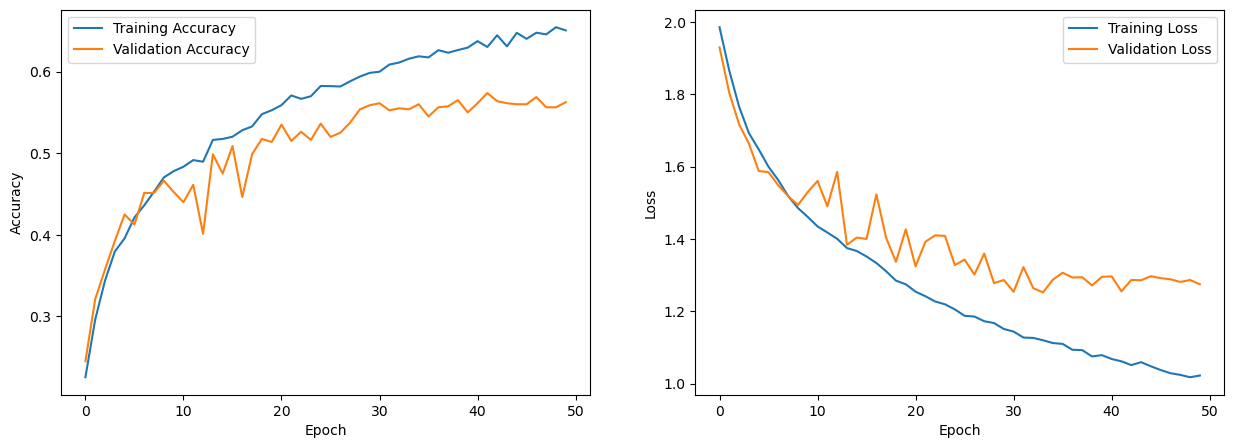

aug_prob:0.9, max_mask_pct:0.2,n_freq_masks:1,n_time_masks:1
Epoch: 0, Train Loss: 1.99, Training Accuracy: 0.22
 Validation Loss: 1.93, Validation Accuracy: 0.24
--------------------------------------------
Epoch: 1, Train Loss: 1.86, Training Accuracy: 0.30
 Validation Loss: 1.81, Validation Accuracy: 0.31
--------------------------------------------
Epoch: 2, Train Loss: 1.76, Training Accuracy: 0.36
 Validation Loss: 1.71, Validation Accuracy: 0.37
--------------------------------------------
Epoch: 3, Train Loss: 1.70, Training Accuracy: 0.38
 Validation Loss: 1.69, Validation Accuracy: 0.38
--------------------------------------------
Epoch: 4, Train Loss: 1.64, Training Accuracy: 0.40
 Validation Loss: 1.63, Validation Accuracy: 0.41
--------------------------------------------
Epoch: 5, Train Loss: 1.60, Training Accuracy: 0.42
 Validation Loss: 1.59, Validation Accuracy: 0.43
--------------------------------------------
Epoch: 6, Train Loss: 1.57, Training Accuracy: 0.43
 Vali

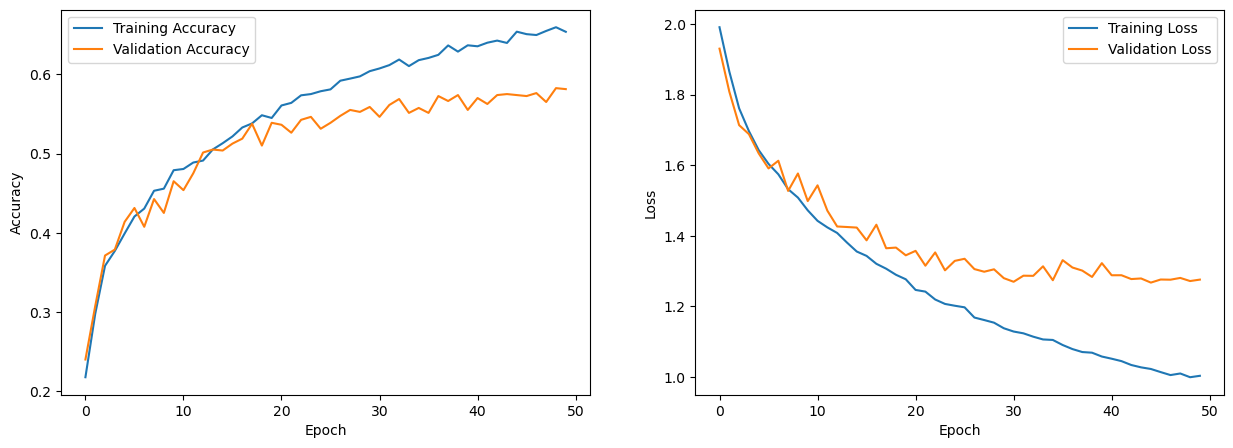

aug_prob:0.9, max_mask_pct:0.2,n_freq_masks:2,n_time_masks:2
Epoch: 0, Train Loss: 2.02, Training Accuracy: 0.21
 Validation Loss: 1.95, Validation Accuracy: 0.24
--------------------------------------------
Epoch: 1, Train Loss: 1.90, Training Accuracy: 0.27
 Validation Loss: 1.85, Validation Accuracy: 0.31
--------------------------------------------
Epoch: 2, Train Loss: 1.81, Training Accuracy: 0.33
 Validation Loss: 1.76, Validation Accuracy: 0.33
--------------------------------------------
Epoch: 3, Train Loss: 1.74, Training Accuracy: 0.35
 Validation Loss: 1.74, Validation Accuracy: 0.34
--------------------------------------------
Epoch: 4, Train Loss: 1.69, Training Accuracy: 0.37
 Validation Loss: 1.65, Validation Accuracy: 0.39
--------------------------------------------
Epoch: 5, Train Loss: 1.66, Training Accuracy: 0.38
 Validation Loss: 1.63, Validation Accuracy: 0.41
--------------------------------------------
Epoch: 6, Train Loss: 1.63, Training Accuracy: 0.40
 Vali

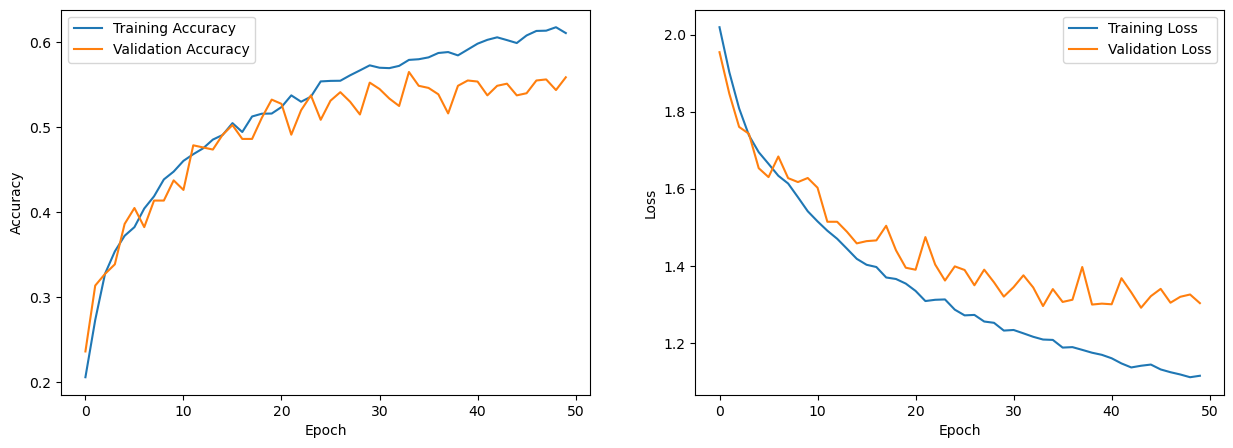

aug_prob:0.9, max_mask_pct:0.3,n_freq_masks:1,n_time_masks:1
Epoch: 0, Train Loss: 2.01, Training Accuracy: 0.21
 Validation Loss: 1.94, Validation Accuracy: 0.25
--------------------------------------------
Epoch: 1, Train Loss: 1.87, Training Accuracy: 0.31
 Validation Loss: 1.80, Validation Accuracy: 0.30
--------------------------------------------
Epoch: 2, Train Loss: 1.77, Training Accuracy: 0.35
 Validation Loss: 1.75, Validation Accuracy: 0.33
--------------------------------------------
Epoch: 3, Train Loss: 1.71, Training Accuracy: 0.37
 Validation Loss: 1.70, Validation Accuracy: 0.39
--------------------------------------------
Epoch: 4, Train Loss: 1.67, Training Accuracy: 0.38
 Validation Loss: 1.66, Validation Accuracy: 0.41
--------------------------------------------
Epoch: 5, Train Loss: 1.64, Training Accuracy: 0.40
 Validation Loss: 1.63, Validation Accuracy: 0.42
--------------------------------------------
Epoch: 6, Train Loss: 1.61, Training Accuracy: 0.42
 Vali

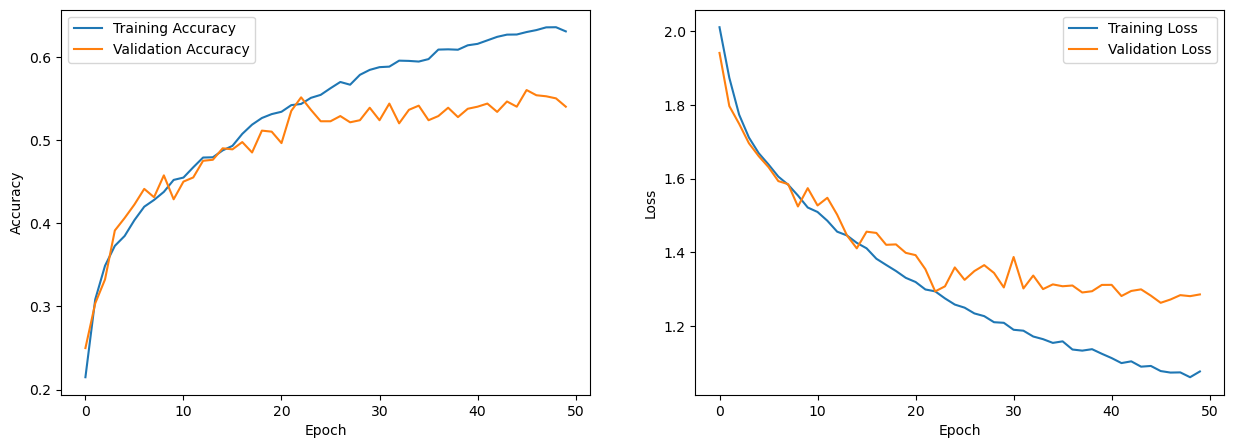

aug_prob:0.9, max_mask_pct:0.3,n_freq_masks:2,n_time_masks:2
Epoch: 0, Train Loss: 2.01, Training Accuracy: 0.21
 Validation Loss: 1.97, Validation Accuracy: 0.23
--------------------------------------------
Epoch: 1, Train Loss: 1.91, Training Accuracy: 0.26
 Validation Loss: 1.88, Validation Accuracy: 0.27
--------------------------------------------
Epoch: 2, Train Loss: 1.85, Training Accuracy: 0.31
 Validation Loss: 1.77, Validation Accuracy: 0.36
--------------------------------------------
Epoch: 3, Train Loss: 1.78, Training Accuracy: 0.34
 Validation Loss: 1.77, Validation Accuracy: 0.31
--------------------------------------------
Epoch: 4, Train Loss: 1.73, Training Accuracy: 0.35
 Validation Loss: 1.72, Validation Accuracy: 0.34
--------------------------------------------
Epoch: 5, Train Loss: 1.70, Training Accuracy: 0.37
 Validation Loss: 1.67, Validation Accuracy: 0.37
--------------------------------------------
Epoch: 6, Train Loss: 1.67, Training Accuracy: 0.38
 Vali

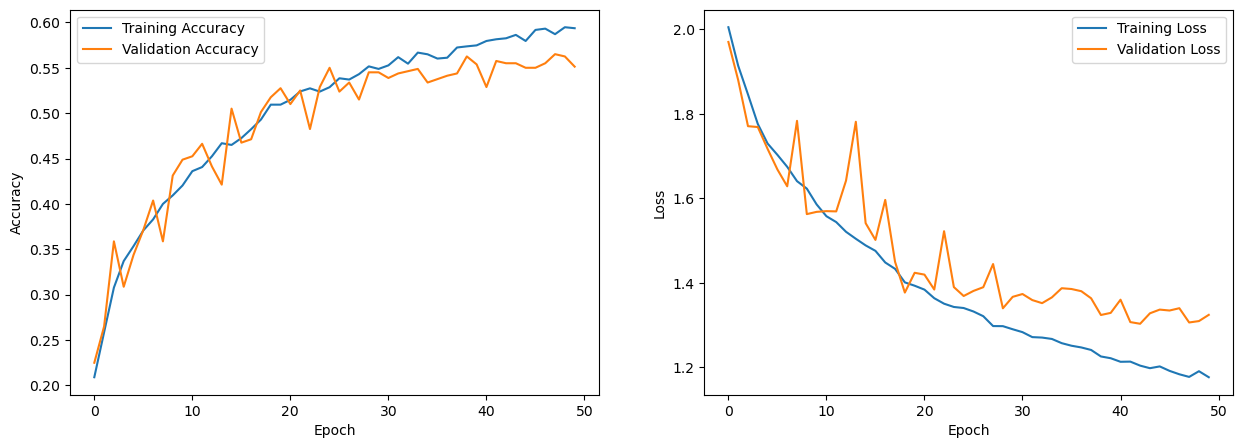

aug_prob:1, max_mask_pct:0.1,n_freq_masks:1,n_time_masks:1
Epoch: 0, Train Loss: 1.99, Training Accuracy: 0.23
 Validation Loss: 1.90, Validation Accuracy: 0.28
--------------------------------------------
Epoch: 1, Train Loss: 1.85, Training Accuracy: 0.32
 Validation Loss: 1.78, Validation Accuracy: 0.31
--------------------------------------------
Epoch: 2, Train Loss: 1.72, Training Accuracy: 0.37
 Validation Loss: 1.69, Validation Accuracy: 0.37
--------------------------------------------
Epoch: 3, Train Loss: 1.65, Training Accuracy: 0.40
 Validation Loss: 1.63, Validation Accuracy: 0.40
--------------------------------------------
Epoch: 4, Train Loss: 1.60, Training Accuracy: 0.42
 Validation Loss: 1.59, Validation Accuracy: 0.45
--------------------------------------------
Epoch: 5, Train Loss: 1.57, Training Accuracy: 0.44
 Validation Loss: 1.57, Validation Accuracy: 0.44
--------------------------------------------
Epoch: 6, Train Loss: 1.52, Training Accuracy: 0.46
 Valida

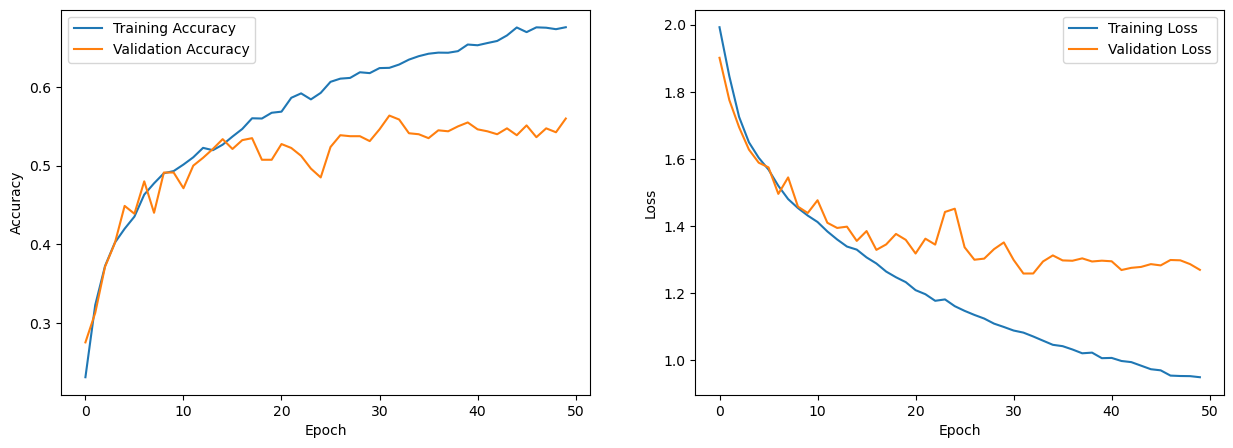

aug_prob:1, max_mask_pct:0.1,n_freq_masks:2,n_time_masks:2
Epoch: 0, Train Loss: 2.00, Training Accuracy: 0.21
 Validation Loss: 1.95, Validation Accuracy: 0.24
--------------------------------------------
Epoch: 1, Train Loss: 1.89, Training Accuracy: 0.29
 Validation Loss: 1.84, Validation Accuracy: 0.30
--------------------------------------------
Epoch: 2, Train Loss: 1.80, Training Accuracy: 0.34
 Validation Loss: 1.76, Validation Accuracy: 0.33
--------------------------------------------
Epoch: 3, Train Loss: 1.73, Training Accuracy: 0.37
 Validation Loss: 1.68, Validation Accuracy: 0.39
--------------------------------------------
Epoch: 4, Train Loss: 1.67, Training Accuracy: 0.38
 Validation Loss: 1.64, Validation Accuracy: 0.42
--------------------------------------------
Epoch: 5, Train Loss: 1.64, Training Accuracy: 0.40
 Validation Loss: 1.62, Validation Accuracy: 0.41
--------------------------------------------
Epoch: 6, Train Loss: 1.60, Training Accuracy: 0.42
 Valida

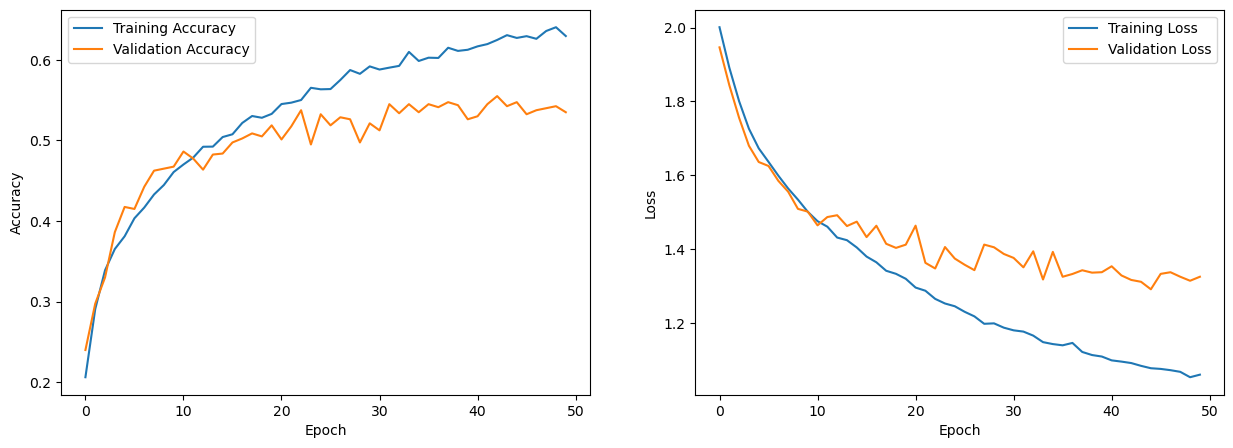

aug_prob:1, max_mask_pct:0.2,n_freq_masks:1,n_time_masks:1
Epoch: 0, Train Loss: 1.99, Training Accuracy: 0.21
 Validation Loss: 1.89, Validation Accuracy: 0.27
--------------------------------------------
Epoch: 1, Train Loss: 1.84, Training Accuracy: 0.32
 Validation Loss: 1.76, Validation Accuracy: 0.33
--------------------------------------------
Epoch: 2, Train Loss: 1.73, Training Accuracy: 0.35
 Validation Loss: 1.70, Validation Accuracy: 0.37
--------------------------------------------
Epoch: 3, Train Loss: 1.67, Training Accuracy: 0.38
 Validation Loss: 1.66, Validation Accuracy: 0.36
--------------------------------------------
Epoch: 4, Train Loss: 1.64, Training Accuracy: 0.40
 Validation Loss: 1.62, Validation Accuracy: 0.40
--------------------------------------------
Epoch: 5, Train Loss: 1.61, Training Accuracy: 0.40
 Validation Loss: 1.61, Validation Accuracy: 0.40
--------------------------------------------
Epoch: 6, Train Loss: 1.58, Training Accuracy: 0.42
 Valida

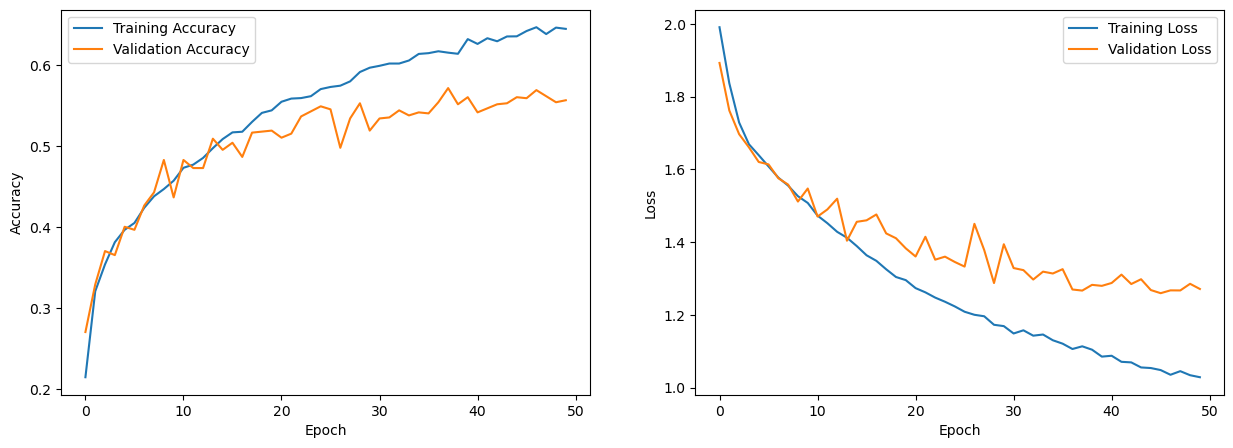

aug_prob:1, max_mask_pct:0.2,n_freq_masks:2,n_time_masks:2
Epoch: 0, Train Loss: 2.01, Training Accuracy: 0.20
 Validation Loss: 1.95, Validation Accuracy: 0.23
--------------------------------------------
Epoch: 1, Train Loss: 1.91, Training Accuracy: 0.27
 Validation Loss: 1.87, Validation Accuracy: 0.28
--------------------------------------------
Epoch: 2, Train Loss: 1.83, Training Accuracy: 0.32
 Validation Loss: 1.75, Validation Accuracy: 0.32
--------------------------------------------
Epoch: 3, Train Loss: 1.74, Training Accuracy: 0.35
 Validation Loss: 1.68, Validation Accuracy: 0.38
--------------------------------------------
Epoch: 4, Train Loss: 1.68, Training Accuracy: 0.37
 Validation Loss: 1.73, Validation Accuracy: 0.36
--------------------------------------------
Epoch: 5, Train Loss: 1.65, Training Accuracy: 0.39
 Validation Loss: 1.61, Validation Accuracy: 0.41
--------------------------------------------
Epoch: 6, Train Loss: 1.63, Training Accuracy: 0.40
 Valida

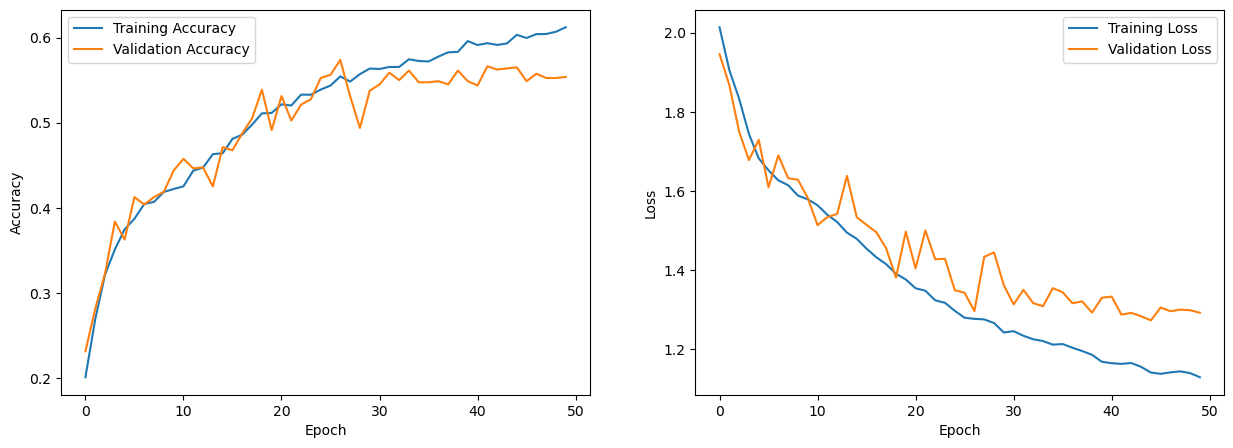

aug_prob:1, max_mask_pct:0.3,n_freq_masks:1,n_time_masks:1
Epoch: 0, Train Loss: 2.01, Training Accuracy: 0.23
 Validation Loss: 1.94, Validation Accuracy: 0.29
--------------------------------------------
Epoch: 1, Train Loss: 1.89, Training Accuracy: 0.30
 Validation Loss: 1.80, Validation Accuracy: 0.34
--------------------------------------------
Epoch: 2, Train Loss: 1.78, Training Accuracy: 0.35
 Validation Loss: 1.70, Validation Accuracy: 0.40
--------------------------------------------
Epoch: 3, Train Loss: 1.71, Training Accuracy: 0.37
 Validation Loss: 1.67, Validation Accuracy: 0.41
--------------------------------------------
Epoch: 4, Train Loss: 1.66, Training Accuracy: 0.40
 Validation Loss: 1.61, Validation Accuracy: 0.42
--------------------------------------------
Epoch: 5, Train Loss: 1.62, Training Accuracy: 0.42
 Validation Loss: 1.60, Validation Accuracy: 0.42
--------------------------------------------
Epoch: 6, Train Loss: 1.59, Training Accuracy: 0.43
 Valida

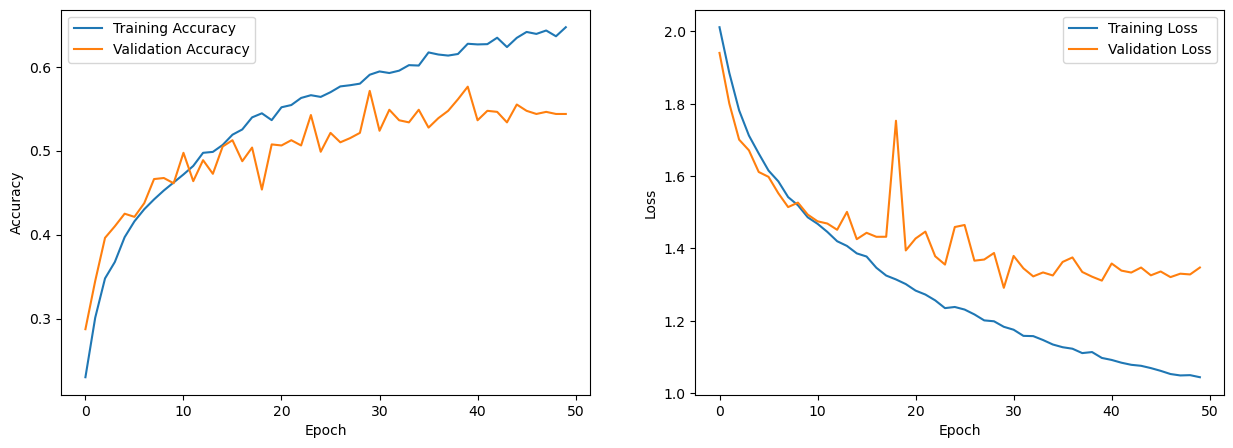

aug_prob:1, max_mask_pct:0.3,n_freq_masks:2,n_time_masks:2
Epoch: 0, Train Loss: 2.01, Training Accuracy: 0.20
 Validation Loss: 1.95, Validation Accuracy: 0.22
--------------------------------------------
Epoch: 1, Train Loss: 1.91, Training Accuracy: 0.26
 Validation Loss: 1.84, Validation Accuracy: 0.31
--------------------------------------------
Epoch: 2, Train Loss: 1.85, Training Accuracy: 0.30
 Validation Loss: 1.75, Validation Accuracy: 0.36
--------------------------------------------
Epoch: 3, Train Loss: 1.78, Training Accuracy: 0.34
 Validation Loss: 1.75, Validation Accuracy: 0.33
--------------------------------------------
Epoch: 4, Train Loss: 1.74, Training Accuracy: 0.36
 Validation Loss: 1.70, Validation Accuracy: 0.38
--------------------------------------------
Epoch: 5, Train Loss: 1.70, Training Accuracy: 0.37
 Validation Loss: 1.73, Validation Accuracy: 0.35
--------------------------------------------
Epoch: 6, Train Loss: 1.67, Training Accuracy: 0.38
 Valida

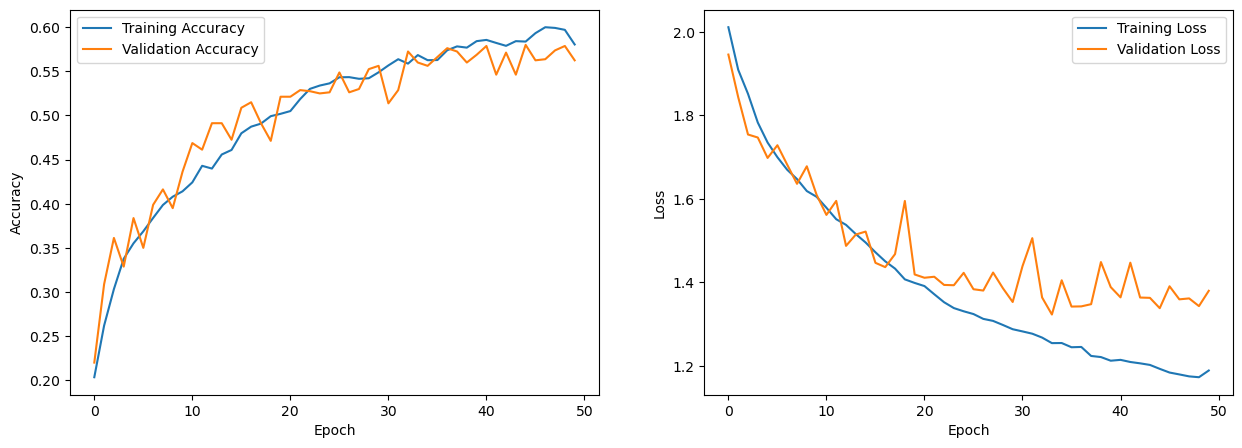

Gridsearch time:  49419.68755364418


In [69]:
import time
start = time.time()
for augment_prob in [0.7,0.8,0.9,1]:
    for max_mask_pct in [0.1,0.2,0.3]:
        for n_freq_masks, n_time_masks in [(1,1),(2,2)]:
            print("aug_prob:{a}, max_mask_pct:{b},n_freq_masks:{c},n_time_masks:{d}".format(a=augment_prob,b=max_mask_pct,
                                                                                            c=n_freq_masks,d=n_time_masks))
            dataset_train = FMA2D_spec(DATA_DIR, train_ids, transforms = True, augment_prob = augment_prob ,
                                       max_mask_pct = max_mask_pct, n_freq_masks = n_freq_masks, n_time_masks = n_time_masks)
            dataset_valid = FMA2D_spec(DATA_DIR, val_ids, transforms = False)
            dataset_test = FMA2D_spec(DATA_DIR, test_ids)
            # to start with a clean clean slate at each iteration, if you don't do zero_grad(),  
            # the running sum of gradients in batch normalization layers isn't reset
            myModel = None
            myModel = SimpleCNN
            myModel.zero_grad()
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            myModel = myModel.to(device)
            # Check that it is on Cuda
            next(myModel.parameters()).device
            
            # Create training and validation data loaders
            train_dl_sp = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)
            val_dl_sp = torch.utils.data.DataLoader(dataset_valid, batch_size=32, shuffle=True)
            
            
            training_valid(myModel, train_dl_sp, val_dl_sp, num_epochs = 50)
elapsed = time.time() - start
print("Gridsearch time: ", elapsed)

### Another gridsearch with more augmentation

In [72]:
for augment_prob in [1]:
    for max_mask_pct in [0.3,0.4,0.5,0.6,0.7]:
        for n_freq_masks, n_time_masks in [(1,1),(2,2),(3,3)]:
            print("aug_prob:{a}, max_mask_pct:{b},n_freq_masks:{c},n_time_masks:{d}".format(a=augment_prob,b=max_mask_pct,
                                                                                            c=n_freq_masks,d=n_time_masks))

aug_prob:1, max_mask_pct:0.3,n_freq_masks:1,n_time_masks:1
aug_prob:1, max_mask_pct:0.3,n_freq_masks:2,n_time_masks:2
aug_prob:1, max_mask_pct:0.3,n_freq_masks:3,n_time_masks:3
aug_prob:1, max_mask_pct:0.4,n_freq_masks:1,n_time_masks:1
aug_prob:1, max_mask_pct:0.4,n_freq_masks:2,n_time_masks:2
aug_prob:1, max_mask_pct:0.4,n_freq_masks:3,n_time_masks:3
aug_prob:1, max_mask_pct:0.5,n_freq_masks:1,n_time_masks:1
aug_prob:1, max_mask_pct:0.5,n_freq_masks:2,n_time_masks:2
aug_prob:1, max_mask_pct:0.5,n_freq_masks:3,n_time_masks:3
aug_prob:1, max_mask_pct:0.6,n_freq_masks:1,n_time_masks:1
aug_prob:1, max_mask_pct:0.6,n_freq_masks:2,n_time_masks:2
aug_prob:1, max_mask_pct:0.6,n_freq_masks:3,n_time_masks:3
aug_prob:1, max_mask_pct:0.7,n_freq_masks:1,n_time_masks:1
aug_prob:1, max_mask_pct:0.7,n_freq_masks:2,n_time_masks:2
aug_prob:1, max_mask_pct:0.7,n_freq_masks:3,n_time_masks:3


aug_prob:1, max_mask_pct:0.4,n_freq_masks:1,n_time_masks:1
Epoch: 0, Train Loss: 2.01, Training Accuracy: 0.21
 Validation Loss: 1.95, Validation Accuracy: 0.25
--------------------------------------------
Epoch: 1, Train Loss: 1.90, Training Accuracy: 0.28
 Validation Loss: 1.86, Validation Accuracy: 0.31
--------------------------------------------
Epoch: 2, Train Loss: 1.81, Training Accuracy: 0.32
 Validation Loss: 1.74, Validation Accuracy: 0.36
--------------------------------------------
Epoch: 3, Train Loss: 1.74, Training Accuracy: 0.36
 Validation Loss: 1.76, Validation Accuracy: 0.35
--------------------------------------------
Epoch: 4, Train Loss: 1.69, Training Accuracy: 0.37
 Validation Loss: 1.68, Validation Accuracy: 0.41
--------------------------------------------
Epoch: 5, Train Loss: 1.66, Training Accuracy: 0.39
 Validation Loss: 1.65, Validation Accuracy: 0.40
--------------------------------------------
Epoch: 6, Train Loss: 1.63, Training Accuracy: 0.40
 Valida

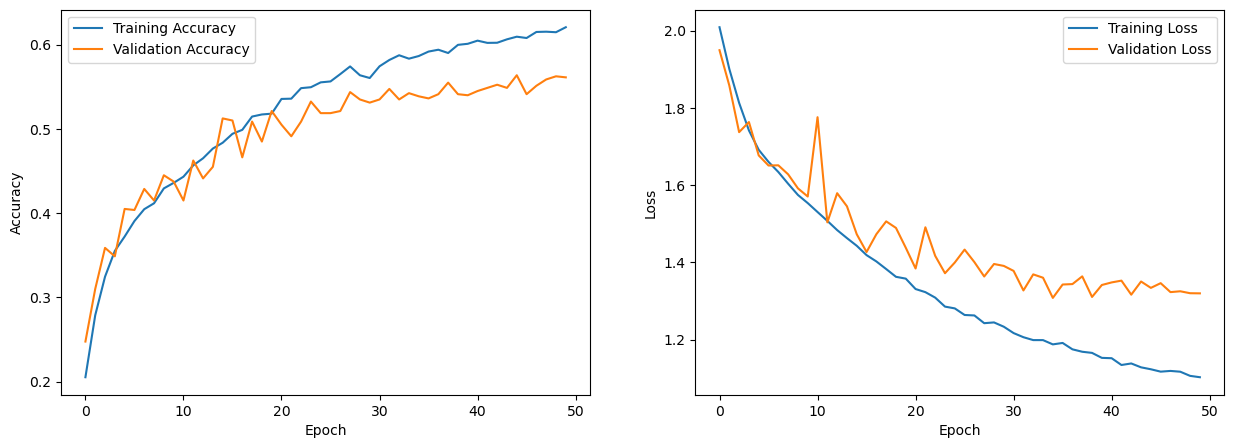

aug_prob:1, max_mask_pct:0.4,n_freq_masks:2,n_time_masks:2
Epoch: 0, Train Loss: 1.99, Training Accuracy: 0.20
 Validation Loss: 1.98, Validation Accuracy: 0.20
--------------------------------------------
Epoch: 1, Train Loss: 1.92, Training Accuracy: 0.26
 Validation Loss: 1.89, Validation Accuracy: 0.26
--------------------------------------------
Epoch: 2, Train Loss: 1.88, Training Accuracy: 0.28
 Validation Loss: 1.82, Validation Accuracy: 0.27
--------------------------------------------
Epoch: 3, Train Loss: 1.82, Training Accuracy: 0.32
 Validation Loss: 1.76, Validation Accuracy: 0.31
--------------------------------------------
Epoch: 4, Train Loss: 1.77, Training Accuracy: 0.35
 Validation Loss: 1.72, Validation Accuracy: 0.37
--------------------------------------------
Epoch: 5, Train Loss: 1.73, Training Accuracy: 0.36
 Validation Loss: 1.68, Validation Accuracy: 0.39
--------------------------------------------
Epoch: 6, Train Loss: 1.70, Training Accuracy: 0.37
 Valida

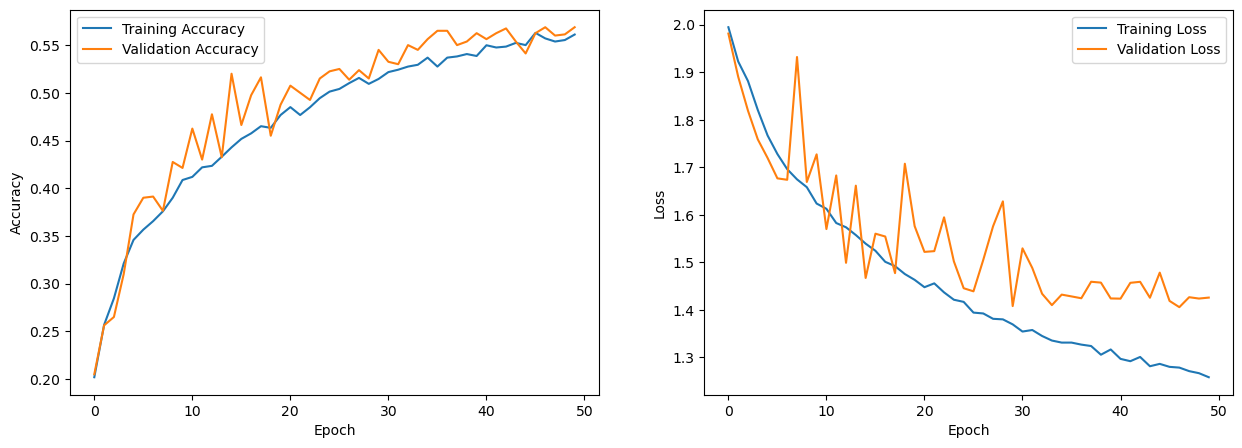

aug_prob:1, max_mask_pct:0.4,n_freq_masks:3,n_time_masks:3
Epoch: 0, Train Loss: 2.02, Training Accuracy: 0.20
 Validation Loss: 1.97, Validation Accuracy: 0.24
--------------------------------------------
Epoch: 1, Train Loss: 1.93, Training Accuracy: 0.24
 Validation Loss: 1.93, Validation Accuracy: 0.21
--------------------------------------------
Epoch: 2, Train Loss: 1.90, Training Accuracy: 0.27
 Validation Loss: 1.88, Validation Accuracy: 0.21
--------------------------------------------
Epoch: 3, Train Loss: 1.86, Training Accuracy: 0.29
 Validation Loss: 1.96, Validation Accuracy: 0.23
--------------------------------------------
Epoch: 4, Train Loss: 1.82, Training Accuracy: 0.31
 Validation Loss: 2.05, Validation Accuracy: 0.26
--------------------------------------------
Epoch: 5, Train Loss: 1.79, Training Accuracy: 0.32
 Validation Loss: 1.89, Validation Accuracy: 0.34
--------------------------------------------
Epoch: 6, Train Loss: 1.77, Training Accuracy: 0.34
 Valida

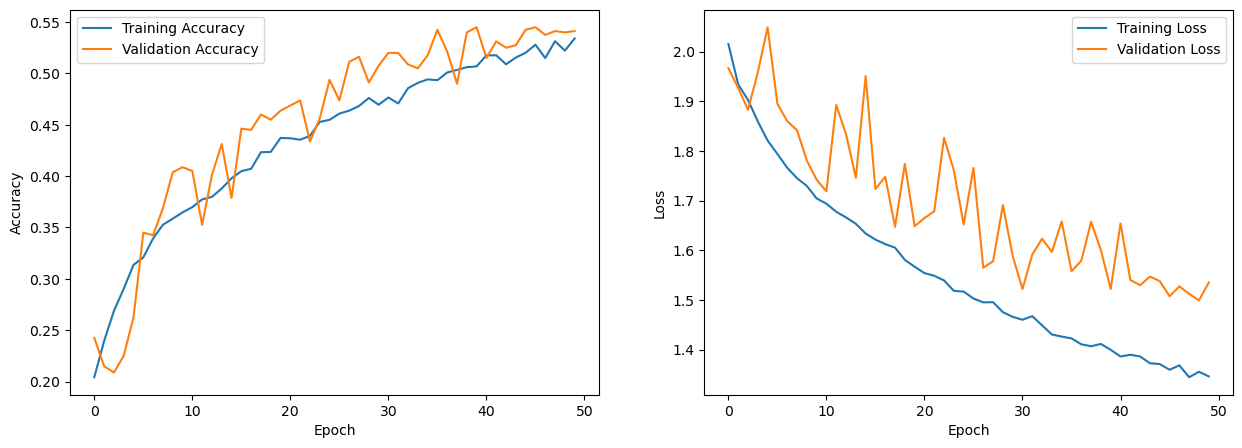

aug_prob:1, max_mask_pct:0.5,n_freq_masks:1,n_time_masks:1
Epoch: 0, Train Loss: 2.00, Training Accuracy: 0.21
 Validation Loss: 1.95, Validation Accuracy: 0.23
--------------------------------------------
Epoch: 1, Train Loss: 1.90, Training Accuracy: 0.26
 Validation Loss: 1.86, Validation Accuracy: 0.29
--------------------------------------------
Epoch: 2, Train Loss: 1.84, Training Accuracy: 0.31
 Validation Loss: 1.77, Validation Accuracy: 0.34
--------------------------------------------
Epoch: 3, Train Loss: 1.77, Training Accuracy: 0.34
 Validation Loss: 1.73, Validation Accuracy: 0.35
--------------------------------------------
Epoch: 4, Train Loss: 1.73, Training Accuracy: 0.36
 Validation Loss: 1.66, Validation Accuracy: 0.39
--------------------------------------------
Epoch: 5, Train Loss: 1.69, Training Accuracy: 0.37
 Validation Loss: 1.64, Validation Accuracy: 0.41
--------------------------------------------
Epoch: 6, Train Loss: 1.66, Training Accuracy: 0.38
 Valida

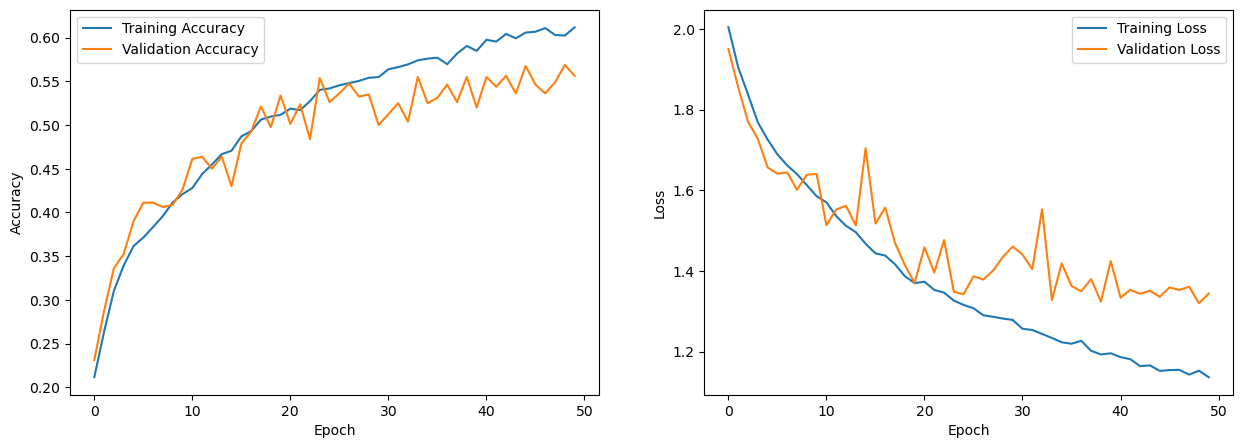

aug_prob:1, max_mask_pct:0.5,n_freq_masks:2,n_time_masks:2
Epoch: 0, Train Loss: 2.00, Training Accuracy: 0.19
 Validation Loss: 1.97, Validation Accuracy: 0.20
--------------------------------------------
Epoch: 1, Train Loss: 1.92, Training Accuracy: 0.25
 Validation Loss: 1.89, Validation Accuracy: 0.23
--------------------------------------------
Epoch: 2, Train Loss: 1.87, Training Accuracy: 0.28
 Validation Loss: 1.81, Validation Accuracy: 0.24
--------------------------------------------
Epoch: 3, Train Loss: 1.82, Training Accuracy: 0.31
 Validation Loss: 1.81, Validation Accuracy: 0.32
--------------------------------------------
Epoch: 4, Train Loss: 1.79, Training Accuracy: 0.32
 Validation Loss: 1.87, Validation Accuracy: 0.34
--------------------------------------------
Epoch: 5, Train Loss: 1.74, Training Accuracy: 0.35
 Validation Loss: 1.77, Validation Accuracy: 0.37
--------------------------------------------
Epoch: 6, Train Loss: 1.73, Training Accuracy: 0.35
 Valida

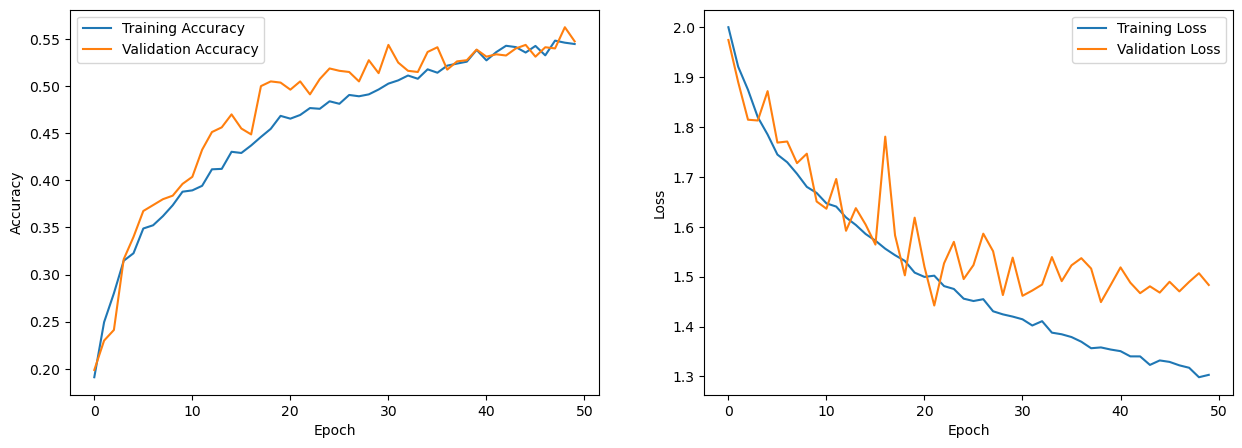

aug_prob:1, max_mask_pct:0.5,n_freq_masks:3,n_time_masks:3
Epoch: 0, Train Loss: 2.01, Training Accuracy: 0.19
 Validation Loss: 2.07, Validation Accuracy: 0.16
--------------------------------------------
Epoch: 1, Train Loss: 1.94, Training Accuracy: 0.23
 Validation Loss: 2.06, Validation Accuracy: 0.13
--------------------------------------------
Epoch: 2, Train Loss: 1.93, Training Accuracy: 0.25
 Validation Loss: 1.97, Validation Accuracy: 0.22
--------------------------------------------
Epoch: 3, Train Loss: 1.92, Training Accuracy: 0.26
 Validation Loss: 1.92, Validation Accuracy: 0.22
--------------------------------------------
Epoch: 4, Train Loss: 1.89, Training Accuracy: 0.28
 Validation Loss: 1.83, Validation Accuracy: 0.31
--------------------------------------------
Epoch: 5, Train Loss: 1.86, Training Accuracy: 0.29
 Validation Loss: 1.82, Validation Accuracy: 0.28
--------------------------------------------
Epoch: 6, Train Loss: 1.84, Training Accuracy: 0.30
 Valida

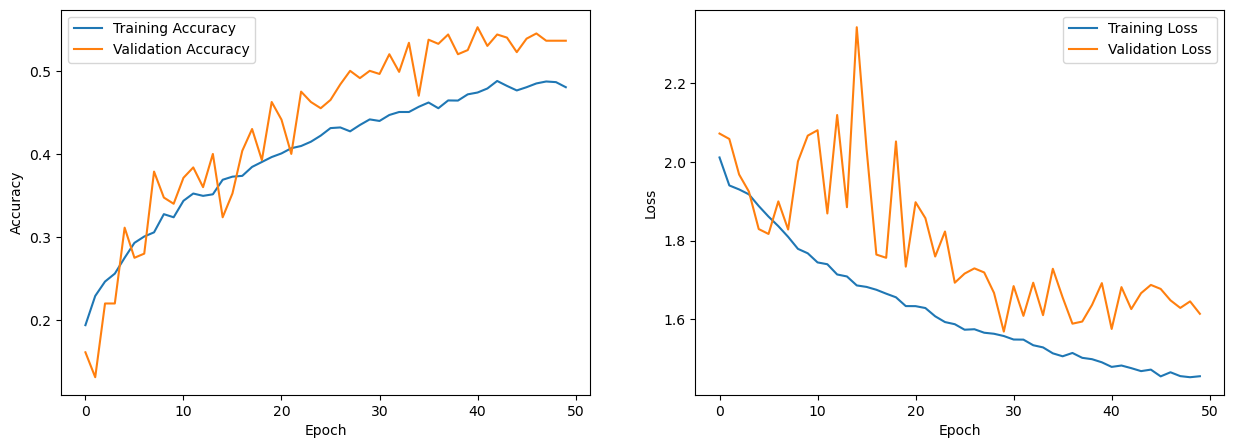

aug_prob:1, max_mask_pct:0.6,n_freq_masks:1,n_time_masks:1
Epoch: 0, Train Loss: 1.98, Training Accuracy: 0.22
 Validation Loss: 1.94, Validation Accuracy: 0.25
--------------------------------------------
Epoch: 1, Train Loss: 1.91, Training Accuracy: 0.26
 Validation Loss: 1.86, Validation Accuracy: 0.30
--------------------------------------------
Epoch: 2, Train Loss: 1.85, Training Accuracy: 0.31
 Validation Loss: 1.75, Validation Accuracy: 0.34
--------------------------------------------
Epoch: 3, Train Loss: 1.79, Training Accuracy: 0.35
 Validation Loss: 1.73, Validation Accuracy: 0.38
--------------------------------------------
Epoch: 4, Train Loss: 1.75, Training Accuracy: 0.35
 Validation Loss: 1.69, Validation Accuracy: 0.40
--------------------------------------------
Epoch: 5, Train Loss: 1.71, Training Accuracy: 0.36
 Validation Loss: 1.65, Validation Accuracy: 0.39
--------------------------------------------
Epoch: 6, Train Loss: 1.68, Training Accuracy: 0.38
 Valida

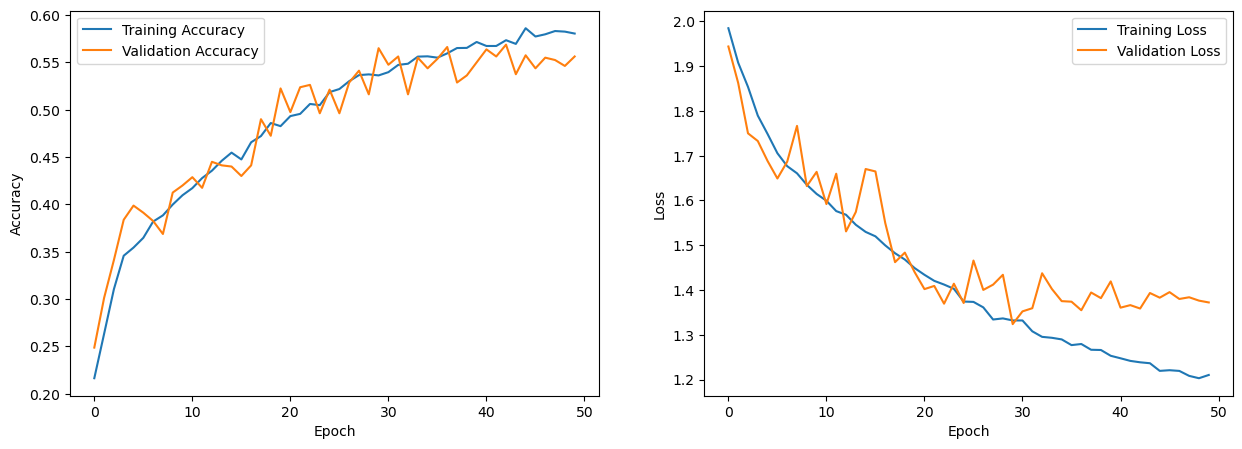

aug_prob:1, max_mask_pct:0.6,n_freq_masks:2,n_time_masks:2
Epoch: 0, Train Loss: 2.00, Training Accuracy: 0.19
 Validation Loss: 1.98, Validation Accuracy: 0.23
--------------------------------------------
Epoch: 1, Train Loss: 1.92, Training Accuracy: 0.26
 Validation Loss: 1.91, Validation Accuracy: 0.27
--------------------------------------------
Epoch: 2, Train Loss: 1.89, Training Accuracy: 0.28
 Validation Loss: 1.84, Validation Accuracy: 0.30
--------------------------------------------
Epoch: 3, Train Loss: 1.85, Training Accuracy: 0.30
 Validation Loss: 1.78, Validation Accuracy: 0.35
--------------------------------------------
Epoch: 4, Train Loss: 1.82, Training Accuracy: 0.31
 Validation Loss: 1.80, Validation Accuracy: 0.35
--------------------------------------------
Epoch: 5, Train Loss: 1.79, Training Accuracy: 0.32
 Validation Loss: 1.82, Validation Accuracy: 0.34
--------------------------------------------
Epoch: 6, Train Loss: 1.77, Training Accuracy: 0.34
 Valida

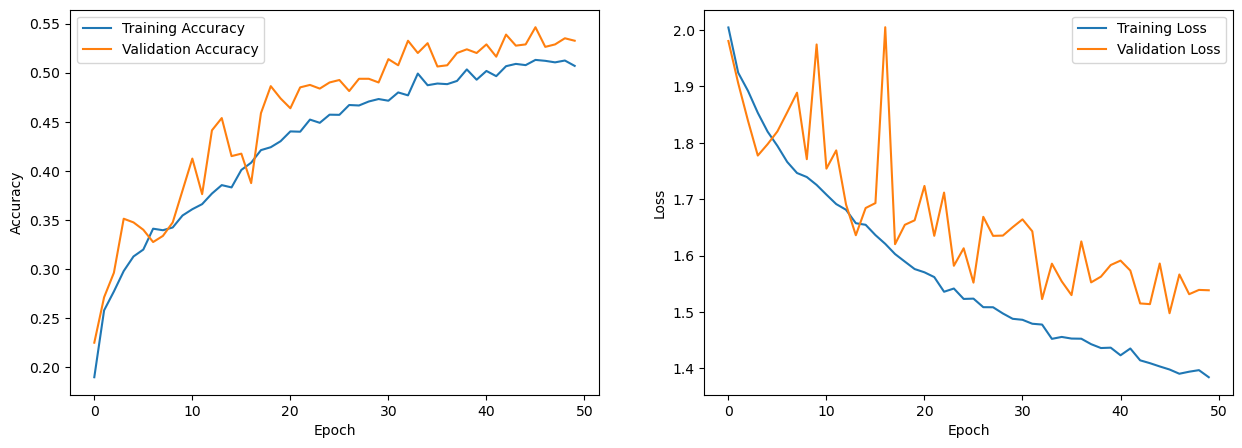

aug_prob:1, max_mask_pct:0.6,n_freq_masks:3,n_time_masks:3
Epoch: 0, Train Loss: 1.99, Training Accuracy: 0.21
 Validation Loss: 2.02, Validation Accuracy: 0.16
--------------------------------------------
Epoch: 1, Train Loss: 1.94, Training Accuracy: 0.24
 Validation Loss: 2.00, Validation Accuracy: 0.18
--------------------------------------------
Epoch: 2, Train Loss: 1.93, Training Accuracy: 0.24
 Validation Loss: 1.95, Validation Accuracy: 0.24
--------------------------------------------
Epoch: 3, Train Loss: 1.92, Training Accuracy: 0.27
 Validation Loss: 1.87, Validation Accuracy: 0.27
--------------------------------------------
Epoch: 4, Train Loss: 1.89, Training Accuracy: 0.27
 Validation Loss: 1.82, Validation Accuracy: 0.29
--------------------------------------------
Epoch: 5, Train Loss: 1.87, Training Accuracy: 0.28
 Validation Loss: 1.75, Validation Accuracy: 0.34
--------------------------------------------
Epoch: 6, Train Loss: 1.85, Training Accuracy: 0.30
 Valida

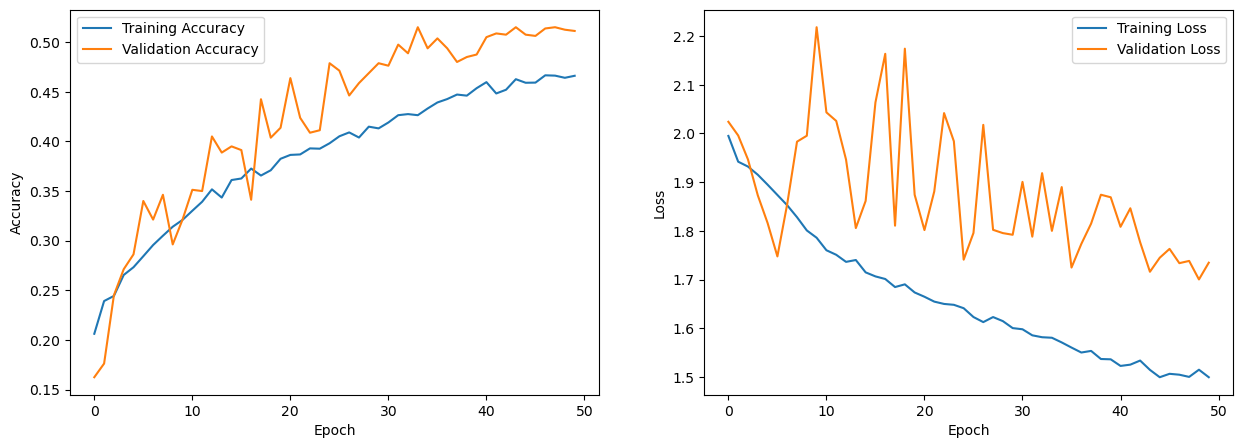

aug_prob:1, max_mask_pct:0.7,n_freq_masks:1,n_time_masks:1
Epoch: 0, Train Loss: 2.00, Training Accuracy: 0.21
 Validation Loss: 1.96, Validation Accuracy: 0.27
--------------------------------------------
Epoch: 1, Train Loss: 1.92, Training Accuracy: 0.26
 Validation Loss: 1.86, Validation Accuracy: 0.32
--------------------------------------------
Epoch: 2, Train Loss: 1.87, Training Accuracy: 0.29
 Validation Loss: 1.77, Validation Accuracy: 0.35
--------------------------------------------
Epoch: 3, Train Loss: 1.81, Training Accuracy: 0.32
 Validation Loss: 1.75, Validation Accuracy: 0.36
--------------------------------------------
Epoch: 4, Train Loss: 1.77, Training Accuracy: 0.34
 Validation Loss: 1.70, Validation Accuracy: 0.38
--------------------------------------------
Epoch: 5, Train Loss: 1.73, Training Accuracy: 0.36
 Validation Loss: 1.71, Validation Accuracy: 0.34
--------------------------------------------
Epoch: 6, Train Loss: 1.70, Training Accuracy: 0.38
 Valida

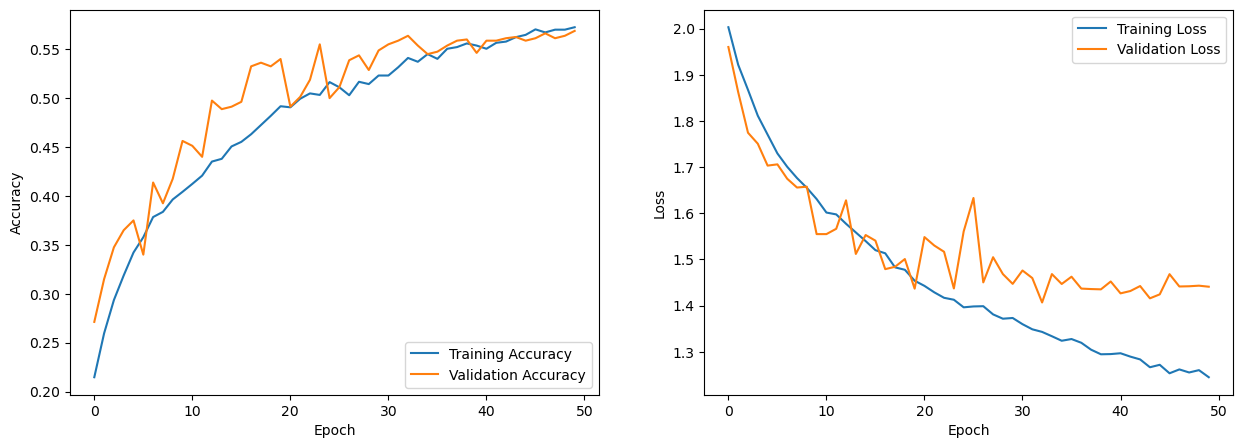

aug_prob:1, max_mask_pct:0.7,n_freq_masks:2,n_time_masks:2
Epoch: 0, Train Loss: 1.98, Training Accuracy: 0.21
 Validation Loss: 1.98, Validation Accuracy: 0.25
--------------------------------------------
Epoch: 1, Train Loss: 1.94, Training Accuracy: 0.24
 Validation Loss: 1.94, Validation Accuracy: 0.27
--------------------------------------------
Epoch: 2, Train Loss: 1.92, Training Accuracy: 0.25
 Validation Loss: 1.87, Validation Accuracy: 0.30
--------------------------------------------
Epoch: 3, Train Loss: 1.90, Training Accuracy: 0.28
 Validation Loss: 1.82, Validation Accuracy: 0.30
--------------------------------------------
Epoch: 4, Train Loss: 1.87, Training Accuracy: 0.29
 Validation Loss: 1.80, Validation Accuracy: 0.31
--------------------------------------------
Epoch: 5, Train Loss: 1.83, Training Accuracy: 0.31
 Validation Loss: 1.82, Validation Accuracy: 0.34
--------------------------------------------
Epoch: 6, Train Loss: 1.81, Training Accuracy: 0.32
 Valida

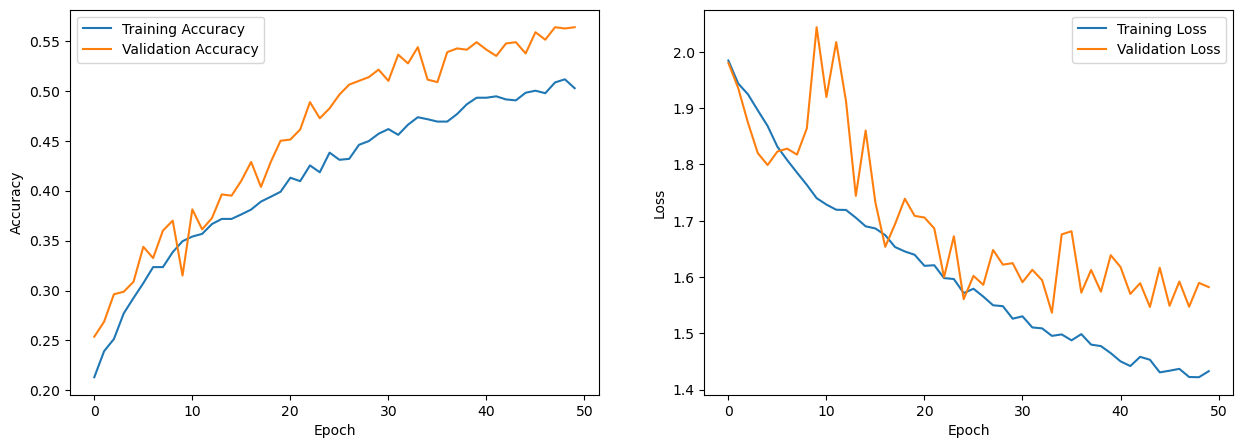

aug_prob:1, max_mask_pct:0.7,n_freq_masks:3,n_time_masks:3
Epoch: 0, Train Loss: 1.99, Training Accuracy: 0.21
 Validation Loss: 1.99, Validation Accuracy: 0.18
--------------------------------------------
Epoch: 1, Train Loss: 1.93, Training Accuracy: 0.24
 Validation Loss: 1.90, Validation Accuracy: 0.26
--------------------------------------------
Epoch: 2, Train Loss: 1.92, Training Accuracy: 0.26
 Validation Loss: 1.85, Validation Accuracy: 0.29
--------------------------------------------
Epoch: 3, Train Loss: 1.90, Training Accuracy: 0.27
 Validation Loss: 1.78, Validation Accuracy: 0.33
--------------------------------------------
Epoch: 4, Train Loss: 1.88, Training Accuracy: 0.29
 Validation Loss: 1.78, Validation Accuracy: 0.31
--------------------------------------------
Epoch: 5, Train Loss: 1.86, Training Accuracy: 0.29
 Validation Loss: 1.76, Validation Accuracy: 0.35
--------------------------------------------
Epoch: 6, Train Loss: 1.85, Training Accuracy: 0.30
 Valida

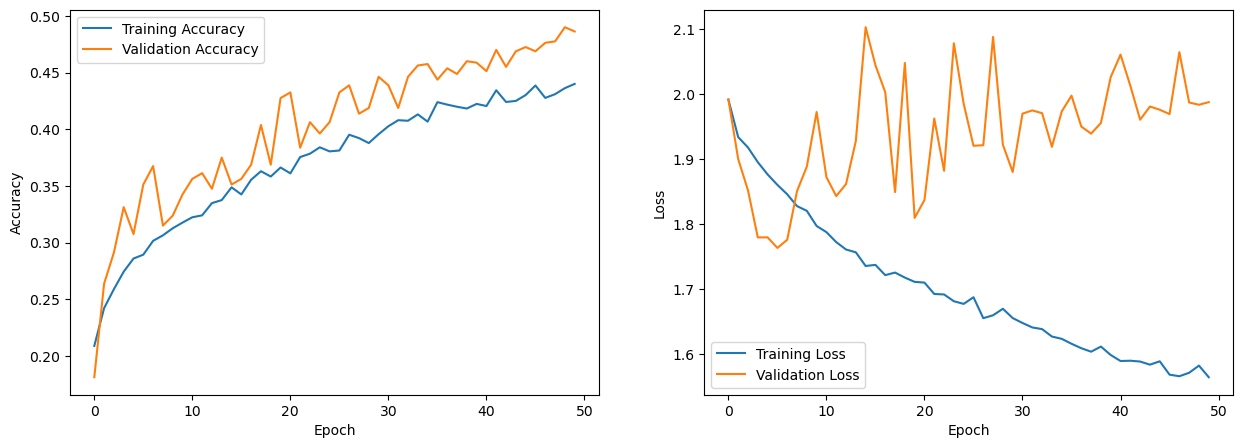

Gridsearch time:  28605.834528923035


In [73]:
import time
start = time.time()
for augment_prob in [1]:
    for max_mask_pct in [0.4,0.5,0.6,0.7]:
        for n_freq_masks, n_time_masks in [(1,1),(2,2),(3,3)]:
            print("aug_prob:{a}, max_mask_pct:{b},n_freq_masks:{c},n_time_masks:{d}".format(a=augment_prob,b=max_mask_pct,
                                                                                            c=n_freq_masks,d=n_time_masks))
            dataset_train = FMA2D_spec(DATA_DIR, train_ids, transforms = True, augment_prob = augment_prob ,
                                       max_mask_pct = max_mask_pct, n_freq_masks = n_freq_masks, n_time_masks = n_time_masks)
            dataset_valid = FMA2D_spec(DATA_DIR, val_ids, transforms = False)
            dataset_test = FMA2D_spec(DATA_DIR, test_ids)
            # to start with a clean clean slate at each iteration, if you don't do zero_grad(),  
            # the running sum of gradients in batch normalization layers isn't reset
            myModel = None
            myModel = SimpleCNN()
            myModel.zero_grad()
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            myModel = myModel.to(device)
            # Check that it is on Cuda
            next(myModel.parameters()).device
            
            # Create training and validation data loaders
            train_dl_sp = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)
            val_dl_sp = torch.utils.data.DataLoader(dataset_valid, batch_size=32, shuffle=True)
            
            
            training_valid(myModel, train_dl_sp, val_dl_sp, num_epochs = 50)
elapsed = time.time() - start
print("Gridsearch time: ", elapsed)